# Problem Statement

Schuster is a multinational retail company dealing in sports goods and accessories. Schuster conducts significant business with hundreds of its vendors, with whom it has credit arrangements. Unfortunately, not all vendors respect credit terms and some of them tend to make payments late. Schuster levies heavy late payment fees, although this procedure is not beneficial to either party in a long-term business relationship. The company has some employees who keep chasing vendors to get the payment on time; this procedure nevertheless also results in non-value-added activities, loss of time and financial impact. Schuster would thus try to understand its customers’ payment behaviour and predict the likelihood of late payments against open invoices.

**Goal** 
Schuster would like to better understand the customers’ payment behaviour based on their past payment patterns (customer segmentation).
Using historical information, it wants to be able to predict the likelihood of delayed payment against open invoices from its customers.
It wants to use this information so that collectors can prioritise their work in following up with customers beforehand to get the payments on time.

**To summarise, as a business analyst, you want to find the answer to these questions:**
How can we analyse the customer transactions data to find different payment behaviours?
In which way can you segregate the customers based on their previous payment patterns/behaviours?
Based on the historical data, can you predict the likelihood of delayed payment against open invoices from the customers?
Can you draw any business insights based on your developed model?

In [1]:
import pandas as pd
import numpy as np
from random import sample
from numpy.random import uniform
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import isnan
import warnings
warnings.filterwarnings('ignore')
#from pandas_profiling import ProfileReport

# Stats Model - For ML
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# From Sklearn - For ML Operations
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score # For Clustering
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score # For Classificiation
from sklearn.metrics import precision_recall_curve # Precision Recall Curve
from sklearn.metrics import roc_auc_score,roc_curve # For AUC-ROC Curve
from sklearn.ensemble import RandomForestClassifier # For Random Forest
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV # For Hyper-Paramter Tuning

# For Jypter Environment
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)

In [2]:
#Reading the data
df = pd.read_csv('Received_Payments_Data.csv')

In [3]:
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [5]:
df.shape

(93937, 16)

In [6]:
df.describe()

,CUSTOMER_NUMBER,RECEIPT_DOC_NO,Local Amount,USD Amount
count,93937.000000,9.390800e+04,9.393700e+04,9.393700e+04
mean,12753.874033,1.583908e+11,1.066470e+06,5.312013e+05
std,14274.170829,3.885359e+10,1.546901e+06,9.508693e+05
min,1044.000000,1.421000e+10,0.000000e+00,0.000000e+00
25%,1888.000000,1.470000e+11,8.198039e+04,3.766298e+04
50%,4003.000000,1.510000e+11,4.053438e+05,1.810010e+05
75%,20884.000000,1.690000e+11,1.425606e+06,5.996137e+05
max,52940.000000,2.970000e+11,1.084983e+07,1.084983e+07


## Exploratory Data Analysis

In [7]:
df['RECEIPT_METHOD'].value_counts()

WIRE             84407
AP/AR Netting     4847
CHEQUE            3472
CASH               782
I/C WIRE           211
PDC                210
I/C Check            6
I/C CASH             2
Name: RECEIPT_METHOD, dtype: int64

In [8]:
df['CUSTOMER_NAME'].value_counts()

SEPH Corp    23143
FARO Corp    15004
PARF Corp     6624
ALLI Corp     5645
AREE Corp     2224
             ...  
KHAW Corp        1
EYEW Corp        1
BRAV Corp        1
NOUS Corp        1
ESSE Corp        1
Name: CUSTOMER_NAME, Length: 690, dtype: int64

In [9]:
df['CUSTOMER_NUMBER'].value_counts()

1409     14698
15768    11052
2315      9716
7530      5382
1888      5062
         ...  
34989        1
35032        1
51402        1
34956        1
2195         1
Name: CUSTOMER_NUMBER, Length: 1054, dtype: int64

In [10]:
#Checking for any missing values
df.isnull().sum()

RECEIPT_METHOD            0
CUSTOMER_NAME             0
CUSTOMER_NUMBER           0
RECEIPT_DOC_NO           29
RECEIPT_DATE              0
CLASS                     0
CURRENCY_CODE             0
Local Amount              0
USD Amount                0
INVOICE_ALLOCATED         0
INVOICE_CREATION_DATE     0
DUE_DATE                  0
PAYMENT_TERM              0
INVOICE_CLASS             0
INVOICE_CURRENCY_CODE     0
INVOICE_TYPE              0
dtype: int64

In [11]:
df[df['RECEIPT_DOC_NO'].isnull()]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
93908,CHEQUE,SENS Corp,48486,NaN,8-Apr-21,PMT,AED,1443.43,1443.43,2.842E+11,16-Feb-21,30-Mar-21,30 Days from EOM,INV,AED,Goods
93909,WIRE,NAMS Corp,21145,NaN,1-Apr-21,PMT,AED,23574.33,23574.33,2.842E+11,24-Jan-21,24-Mar-21,60 Days from Inv Date,INV,AED,Goods
93910,WIRE,GRAN Corp,21312,NaN,8-Apr-21,PMT,USD,41793.60,41793.60,2.842E+11,22-Dec-20,20-Jan-21,30 Days from Inv Date,INV,USD,Goods
93911,WIRE,GRAN Corp,21312,NaN,8-Apr-21,PMT,USD,41793.60,41793.60,2.842E+11,28-Jan-21,28-Jan-21,Immediate,CM,USD,Goods
93912,WIRE,ANAN Corp,21251,NaN,8-Apr-21,PMT,USD,6398.74,6398.74,2.842E+11,11-Mar-21,10-Apr-21,30 Days from Inv Date,INV,AED,Goods
93913,WIRE,NAMS Corp,21145,NaN,7-Apr-21,PMT,AED,4342.99,4342.99,2.842E+11,26-Jan-21,26-Mar-21,60 Days from Inv Date,INV,AED,Goods
93914,WIRE,NAMS Corp,21145,NaN,7-Apr-21,PMT,AED,4342.99,4342.99,2.842E+11,26-Jan-21,26-Mar-21,60 Days from Inv Date,INV,AED,Goods
93915,WIRE,PEAR Corp,21144,NaN,1-Apr-21,PMT,USD,59914.50,59914.50,2.842E+11,4-Jan-21,28-Feb-21,60 Days from Inv Date,INV,USD,Goods
93916,WIRE,PEAR Corp,21144,NaN,1-Apr-21,PMT,USD,59914.50,59914.50,2.842E+11,7-Jan-21,7-Jan-21,Immediate,CM,USD,Goods
93917,WIRE,PEAR Corp,21144,NaN,1-Apr-21,PMT,USD,59914.50,59914.50,2.842E+11,7-Jan-21,7-Jan-21,Immediate,CM,USD,Goods


In [12]:
#Dropping the missing data, as the missing value is very less than the data, hence will not impavt our analysis.
df.dropna(inplace=True)
df.shape

(93908, 16)

In [13]:
date_dtype_col = ["RECEIPT_DATE", "INVOICE_CREATION_DATE", "DUE_DATE"]
for i in date_dtype_col :
    df[i] = pd.to_datetime(df[i])

In [14]:
#We now need to rename "I/C Check" "I/C WIRE" "I/C CASH" to "CHEQUE" "WIRE" "CASH" to maintain consistency in "RECEIPT_METHOD"
df.loc[df['RECEIPT_METHOD'] == 'I/C Check', 'RECEIPT_METHOD'] = 'CHEQUE'
df.loc[df['RECEIPT_METHOD'] == 'I/C WIRE', 'RECEIPT_METHOD'] = 'WIRE'
df.loc[df['RECEIPT_METHOD'] == 'I/C CASH', 'RECEIPT_METHOD'] = 'CASH'

In [15]:
cat_col = []
num_col = []
date_col = []
for i in df.columns :
    if df[i].dtype == 'object' :
        cat_col.append(i)
    elif df[i].dtype == 'datetime64[ns]' :
        date_col.append(i)
    else :
        num_col.append(i)

In [16]:
for i in cat_col :
    print(i)
    print(df[i].value_counts())
    print("-------------------------",'\n')

RECEIPT_METHOD
WIRE             84591
AP/AR Netting     4847
CHEQUE            3476
CASH               784
PDC                210
Name: RECEIPT_METHOD, dtype: int64
------------------------- 

CUSTOMER_NAME
SEPH Corp    23143
FARO Corp    15004
PARF Corp     6624
ALLI Corp     5645
AREE Corp     2224
             ...  
EYEW Corp        1
BRAV Corp        1
NOUS Corp        1
RNA  Corp        1
MARH Corp        1
Name: CUSTOMER_NAME, Length: 690, dtype: int64
------------------------- 

CLASS
PMT    93908
Name: CLASS, dtype: int64
------------------------- 

CURRENCY_CODE
SAR    36495
AED    36273
USD    19501
EUR     1438
GBP      130
BHD       59
KWD       10
QAR        2
Name: CURRENCY_CODE, dtype: int64
------------------------- 

INVOICE_ALLOCATED
1.0721E+11          4359
1.4821E+11          4000
1.5421E+11          3918
1.482E+11           3853
1.6021E+11          3418
                    ... 
IC15214821051078       1
IC15214821051177       1
IC15214820048949       1
IC15214821050

In [17]:
for i in num_col :
    print(i)
    print(df[i].describe())
    print("-------------------------",'\n')

CUSTOMER_NUMBER
count    93908.000000
mean     12750.695979
std      14274.710221
min       1044.000000
25%       1888.000000
50%       4003.000000
75%      20884.000000
max      52940.000000
Name: CUSTOMER_NUMBER, dtype: float64
------------------------- 

RECEIPT_DOC_NO
count    9.390800e+04
mean     1.583908e+11
std      3.885359e+10
min      1.421000e+10
25%      1.470000e+11
50%      1.510000e+11
75%      1.690000e+11
max      2.970000e+11
Name: RECEIPT_DOC_NO, dtype: float64
------------------------- 

Local Amount
count    9.390800e+04
mean     1.066785e+06
std      1.547036e+06
min      0.000000e+00
25%      8.222880e+04
50%      4.055097e+05
75%      1.425606e+06
max      1.084983e+07
Name: Local Amount, dtype: float64
------------------------- 

USD Amount
count    9.390800e+04
mean     5.313510e+05
std      9.509779e+05
min      0.000000e+00
25%      3.766298e+04
50%      1.810010e+05
75%      5.996137e+05
max      1.084983e+07
Name: USD Amount, dtype: float64
--------------

In [18]:
df.nunique()

RECEIPT_METHOD               5
CUSTOMER_NAME              690
CUSTOMER_NUMBER           1053
RECEIPT_DOC_NO              73
RECEIPT_DATE               170
CLASS                        1
CURRENCY_CODE                8
Local Amount              7746
USD Amount                7814
INVOICE_ALLOCATED        12986
INVOICE_CREATION_DATE     1310
DUE_DATE                  1203
PAYMENT_TERM                42
INVOICE_CLASS                3
INVOICE_CURRENCY_CODE       10
INVOICE_TYPE                 2
dtype: int64

In [19]:
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


### Uni-Variate Analysis

In [20]:
print("Categorical_Column :",cat_col,"\n","Numerical_Column :",num_col,"\n","DateTime_Column :",date_col)

Categorical_Column : ['RECEIPT_METHOD', 'CUSTOMER_NAME', 'CLASS', 'CURRENCY_CODE', 'INVOICE_ALLOCATED', 'PAYMENT_TERM', 'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE', 'INVOICE_TYPE'] 
 Numerical_Column : ['CUSTOMER_NUMBER', 'RECEIPT_DOC_NO', 'Local Amount', 'USD Amount'] 
 DateTime_Column : ['RECEIPT_DATE', 'INVOICE_CREATION_DATE', 'DUE_DATE']


#### Date Time Column

In [21]:
# Creating New Features

# Late Payment in no. of days
df['Invoice_Month'] = df['INVOICE_CREATION_DATE'].dt.month
df['Receipt_Month'] = df['RECEIPT_DATE'].dt.month
df['Due_Month'] = df['DUE_DATE'].dt.month
df['Payment_Term_Days'] = (df['DUE_DATE'] - df['INVOICE_CREATION_DATE']).apply(lambda x:x.days)
df["NUM_DAYS_LATE_PAY"] = (df["DUE_DATE"] - df["RECEIPT_DATE"]).apply(lambda x:x.days)

#we will now create a target column called "Default" where a value of "1" indicates that customers have failed to meet deadlines. Specifically, any value less than 0 will be marked as True.
df["Default"] = (df['NUM_DAYS_LATE_PAY'] < 0).astype(int)

**We will now individually go through all the Numerical Columns**

We will drop the columns for "CUSTOMER_NUMBER" and "RECIEPT_DOC_NO" as theses are just the reference numbers on which we wont be performing any analysis and we have other alternative to track this data.

Additionally, we would also be dropping the 'LOCAL_AMOUNT' column as the amount mentioned is in multiple types of currencies. Hence analysing different types of currency with a same approach would hamper our results. Furthermore, we have 'USD_Amount' which has converted the local currency amount in USD. 

In [22]:
df.drop('RECEIPT_DOC_NO', axis=1, inplace= True)
df.drop('CUSTOMER_NUMBER', axis=1, inplace= True)
df.drop('Local Amount', axis=1, inplace= True)

In [23]:
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Invoice_Month,Receipt_Month,Due_Month,Payment_Term_Days,NUM_DAYS_LATE_PAY,Default
0,WIRE,C EA Corp,2021-04-20,PMT,USD,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,11,4,12,58,-111,1
1,WIRE,RADW Corp,2021-01-31,PMT,SAR,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-3,1
2,WIRE,RADW Corp,2021-01-31,PMT,SAR,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,1,1,3,30,29,0
3,WIRE,FARO Corp,2021-01-31,PMT,SAR,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1
4,WIRE,RADW Corp,2021-01-31,PMT,SAR,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1


In [24]:
#For USD Amount column
df["USD Amount"].describe(percentiles=[0.01 ,0.03, 0.05, 0.10, 0.90, 0.95]).round()

count       93908.0
mean       531351.0
std        950978.0
min             0.0
1%              0.0
3%            725.0
5%           1747.0
10%          6472.0
50%        181001.0
90%       1257455.0
95%       2101629.0
max      10849829.0
Name: USD Amount, dtype: float64

Here we observe that the minimum value observed is 0. But amount/payment cannot be 0. Hence we will check further how many such observations are found in the data. 

In [25]:
df[df["USD Amount"] == 0]

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Invoice_Month,Receipt_Month,Due_Month,Payment_Term_Days,NUM_DAYS_LATE_PAY,Default
1091,WIRE,AL F Corp,2021-01-31,PMT,SAR,0.0,1.0119E+11,2019-05-15,2019-06-15,15 Days from EOM,INV,SAR,Goods,5,1,6,31,-596,1
1092,WIRE,AL F Corp,2021-01-31,PMT,SAR,0.0,1.0119E+11,2019-08-06,2019-09-15,15 Days from EOM,INV,SAR,Goods,8,1,9,40,-504,1
1093,WIRE,AL F Corp,2021-01-31,PMT,SAR,0.0,1.0119E+11,2019-12-19,2020-01-15,15 Days from EOM,INV,SAR,Goods,12,1,1,27,-382,1
1094,WIRE,AL F Corp,2021-01-31,PMT,SAR,0.0,11705,2021-01-24,2021-02-15,15 Days from EOM,INV,SAR,Non Goods,1,1,2,22,15,0
1095,WIRE,AL F Corp,2021-01-31,PMT,SAR,0.0,1.0118E+11,2018-08-15,2018-09-15,15 Days from EOM,INV,SAR,Goods,8,1,9,31,-869,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93879,WIRE,SAUD Corp,2021-05-31,PMT,SAR,0.0,2000006359,2020-06-28,2017-08-29,30 Days from Inv Date,INV,SAR,Non Goods,6,5,8,-1034,-1371,1
93880,WIRE,SAUD Corp,2021-05-31,PMT,SAR,0.0,2000006467,2020-06-28,2017-08-31,30 Days from Inv Date,INV,SAR,Non Goods,6,5,8,-1032,-1369,1
93881,WIRE,SAUD Corp,2021-05-31,PMT,SAR,0.0,2000006765,2020-06-28,2017-09-06,30 Days from Inv Date,INV,SAR,Non Goods,6,5,9,-1026,-1363,1
93882,WIRE,SAUD Corp,2021-05-31,PMT,SAR,0.0,2000006917,2020-06-28,2017-09-09,30 Days from Inv Date,INV,SAR,Non Goods,6,5,9,-1023,-1360,1


1126 observations with 0 USD are observed in the data. Keeping this data is irrelevant because it indicates that no payment has to be done. Hence we will remove these rows.

In [26]:
df = df[df['USD Amount'] > 0]

In [27]:
df["USD Amount"].describe(percentiles=[0.05, 0.10, 0.90, 0.95]).round()

count       92782.0
mean       537800.0
std        954917.0
min             1.0
5%           2575.0
10%          7830.0
50%        191527.0
90%       1257455.0
95%       2101629.0
max      10849829.0
Name: USD Amount, dtype: float64

Now the value has changed to a non-zero number. Hence we can now move further.

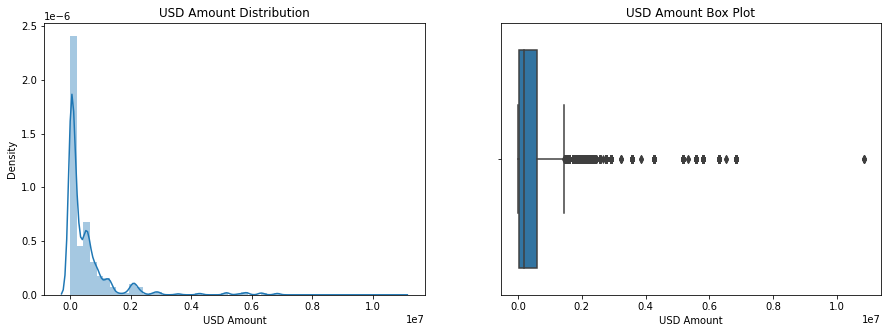

In [28]:
# Visualizing the distribution of 'USD Amount' column

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(df['USD Amount'])
plt.title("USD Amount Distribution")

plt.subplot(1,2,2)
sns.boxplot(df['USD Amount'])
plt.title("USD Amount Box Plot")

plt.show()

In [29]:
#Rounding up the values
df["USD Amount"] = df["USD Amount"].round(2)

### Categorical Columns

In [30]:
#For 'RECIEPT_METHOD'
df['RECEIPT_METHOD'].value_counts()

WIRE             83465
AP/AR Netting     4847
CHEQUE            3476
CASH               784
PDC                210
Name: RECEIPT_METHOD, dtype: int64

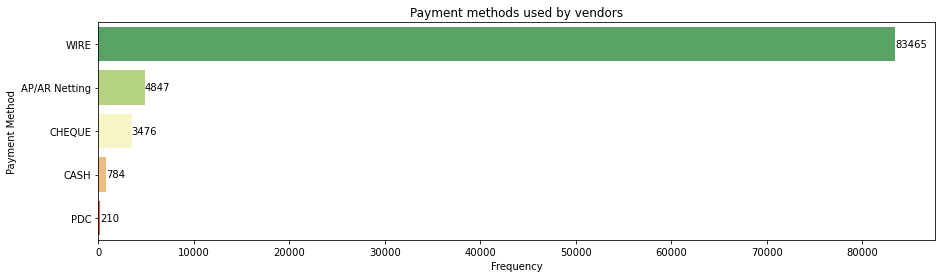

In [31]:
# Visualising the column
plt.figure(figsize=(15,4))
ax = sns.countplot(data=df, y='RECEIPT_METHOD', order=df['RECEIPT_METHOD'].value_counts().index, palette='RdYlGn_r')
for label in ax.containers:
    ax.bar_label(label)
plt.title("Payment methods used by vendors")
plt.ylabel("Payment Method")
plt.xlabel("Frequency")
plt.show()

The most preferred payment method for bill payment is "WIRE".

In [32]:
#For 'CUSTOMER_NAME'
df['CUSTOMER_NAME'].nunique()

689

In [33]:
#Top 20 customers on the basis total invoices
df['CUSTOMER_NAME'].value_counts().head(20)

SEPH Corp    23075
FARO Corp    15004
PARF Corp     6624
ALLI Corp     5645
AREE Corp     2224
DEBE Corp     2133
RADW Corp     1647
YOUG Corp     1480
HABC Corp     1402
CARR Corp      952
AL T Corp      870
VAVA Corp      837
CGR  Corp      834
REAL Corp      802
PARI Corp      759
ARAB Corp      647
LIFE Corp      627
AL S Corp      617
MCT  Corp      585
CWF  Corp      538
Name: CUSTOMER_NAME, dtype: int64

In [34]:
import datetime

In [35]:
# Top 20 customers based on the invoice amounts in USD.
df.groupby('CUSTOMER_NAME')['USD Amount'].sum().sort_values(ascending= False).head(20)


CUSTOMER_NAME
SEPH Corp    3.253371e+10
FARO Corp    5.790071e+09
PARF Corp    3.200510e+09
ALLI Corp    2.580741e+09
AREE Corp    1.125144e+09
HABC Corp    5.343216e+08
RADW Corp    3.622376e+08
L OR Corp    2.955509e+08
CGR  Corp    2.795162e+08
PCD  Corp    2.466070e+08
AL T Corp    2.418545e+08
DEBE Corp    1.600318e+08
DUBA Corp    1.530501e+08
CLAD Corp    1.337310e+08
ARAB Corp    1.202341e+08
WAHR Corp    8.895663e+07
REAL Corp    7.971072e+07
YOUG Corp    7.538007e+07
MCT  Corp    7.043009e+07
QATA Corp    6.365785e+07
Name: USD Amount, dtype: float64

In [36]:
#For 'CLASS'
df['CLASS'].nunique()

1

Here we observed only have one value in class. This will not help us in interpretation. Hence we will drop this column.

In [37]:
df.drop('CLASS', axis= 1, inplace= True)

For the 'CURRENCY_CODE' column:
    Since we have dropped the 'Local amount' column, we need to drop 'CURRENCY_CODE' column as it was dependant on the 'Local amount' column.
    We have a column that uniformly addresses the payment amounts in USD for all.

In [38]:
df.drop('CURRENCY_CODE', axis= 1, inplace= True)

In [39]:
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Invoice_Month,Receipt_Month,Due_Month,Payment_Term_Days,NUM_DAYS_LATE_PAY,Default
0,WIRE,C EA Corp,2021-04-20,101018.63,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,11,4,12,58,-111,1
1,WIRE,RADW Corp,2021-01-31,48990.21,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-3,1
2,WIRE,RADW Corp,2021-01-31,41991.61,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,1,1,3,30,29,0
3,WIRE,FARO Corp,2021-01-31,41991.61,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1
4,WIRE,RADW Corp,2021-01-31,41991.61,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1


For 'INVOICE_ALLOCATED': It is a unique serial number for each observation. Hence it is not useful for our analysis. Therefore we will be dropping this column.

In [40]:
df.drop('INVOICE_ALLOCATED', axis=1, inplace=True)

In [41]:
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Invoice_Month,Receipt_Month,Due_Month,Payment_Term_Days,NUM_DAYS_LATE_PAY,Default
0,WIRE,C EA Corp,2021-04-20,101018.63,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,11,4,12,58,-111,1
1,WIRE,RADW Corp,2021-01-31,48990.21,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-3,1
2,WIRE,RADW Corp,2021-01-31,41991.61,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,1,1,3,30,29,0
3,WIRE,FARO Corp,2021-01-31,41991.61,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1
4,WIRE,RADW Corp,2021-01-31,41991.61,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1


For 'PAYMENT_TERM':

In [42]:
df['PAYMENT_TERM'].nunique()

42

In [43]:
sorted(df['PAYMENT_TERM'].unique().tolist())

['100% Adv Payment',
 '120 Days from EOM',
 '120 Days from Inv Date',
 '15 Days from EOM',
 '15 Days from Inv Date',
 '180 DAYS FROM INV DATE',
 '195 days from Invoice Date',
 '25 DAYS FROM EOM',
 '25% ADVANCE, 75% 30 DAYS FROM INVOICE DATE',
 '30 Days from EOM',
 '30 Days from Inv Date',
 '30% advance 70% after 30 days from invoice date',
 '30% advance 70% after 60 days from invoice date',
 '365 DAYS FROM INVOICE DATE',
 '40 DAYS FROM EOM',
 '45 DAYS + EOM',
 '45 Days from EOM',
 '45 Days from Inv Date',
 '50% ADV 50% 30 Days',
 '50% ADVANCE PAYMENT AND 50% UPON RECEIVING THE SHIPMENT',
 '50% Advance 50% INVDATE+60 DAYS',
 '50% at 30 days and 50% at 60 days',
 '60 Days from EOM',
 '60 Days from Inv Date',
 '7 Days from EOM',
 '7 Days from Inv Date',
 '75 Days from EOM',
 '75 Days from Inv Date',
 '90 Days from EOM',
 '90 Days from Inv Date',
 'Advance with discount',
 'Cash Against Document at sight',
 'Cash on Delivery',
 'EOM',
 'Immediate',
 'Immediate Payment',
 'LC at 60 days',
 

Here we observed that '45 Days from EOM' and '45 DAYS + EOM' are same. Similarly, 'Immediate' and 'Immediate Payment' are same.

Hence we need to replace it with either of the observation.

In [44]:
df['PAYMENT_TERM'] = df['PAYMENT_TERM'].replace('Immediate', 'Immediate Payment')

df['PAYMENT_TERM'] = df['PAYMENT_TERM'].replace('45 DAYS + EOM', '45 Days from EOM')

In [45]:
sorted(df['PAYMENT_TERM'].unique().tolist())

['100% Adv Payment',
 '120 Days from EOM',
 '120 Days from Inv Date',
 '15 Days from EOM',
 '15 Days from Inv Date',
 '180 DAYS FROM INV DATE',
 '195 days from Invoice Date',
 '25 DAYS FROM EOM',
 '25% ADVANCE, 75% 30 DAYS FROM INVOICE DATE',
 '30 Days from EOM',
 '30 Days from Inv Date',
 '30% advance 70% after 30 days from invoice date',
 '30% advance 70% after 60 days from invoice date',
 '365 DAYS FROM INVOICE DATE',
 '40 DAYS FROM EOM',
 '45 Days from EOM',
 '45 Days from Inv Date',
 '50% ADV 50% 30 Days',
 '50% ADVANCE PAYMENT AND 50% UPON RECEIVING THE SHIPMENT',
 '50% Advance 50% INVDATE+60 DAYS',
 '50% at 30 days and 50% at 60 days',
 '60 Days from EOM',
 '60 Days from Inv Date',
 '7 Days from EOM',
 '7 Days from Inv Date',
 '75 Days from EOM',
 '75 Days from Inv Date',
 '90 Days from EOM',
 '90 Days from Inv Date',
 'Advance with discount',
 'Cash Against Document at sight',
 'Cash on Delivery',
 'EOM',
 'Immediate Payment',
 'LC at 60 days',
 'LC at 60 days from FCR/AWB/BL d

In [46]:
df['PAYMENT_TERM'].value_counts(normalize=True)

60 Days from Inv Date                0.212649
30 Days from Inv Date                0.151107
60 Days from EOM                     0.134854
30 Days from EOM                     0.121780
Immediate Payment                    0.112101
                                       ...   
50% at 30 days and 50% at 60 days    0.000022
40 DAYS FROM EOM                     0.000022
180 DAYS FROM INV DATE               0.000011
120 Days from EOM                    0.000011
7 Days from EOM                      0.000011
Name: PAYMENT_TERM, Length: 40, dtype: float64

In [47]:
#Top 10 'PAYMENT_TERM'
df['PAYMENT_TERM'].value_counts().head(10)

60 Days from Inv Date    19730
30 Days from Inv Date    14020
60 Days from EOM         12512
30 Days from EOM         11299
Immediate Payment        10401
15 Days from EOM          7533
90 Days from EOM          3893
45 Days from EOM          3831
45 Days from Inv Date     3550
90 Days from Inv Date     2211
Name: PAYMENT_TERM, dtype: int64

For 'INVOICE_CLASS':

In [48]:
df['INVOICE_CLASS'].value_counts()

INV    87297
CM      4933
DM       552
Name: INVOICE_CLASS, dtype: int64

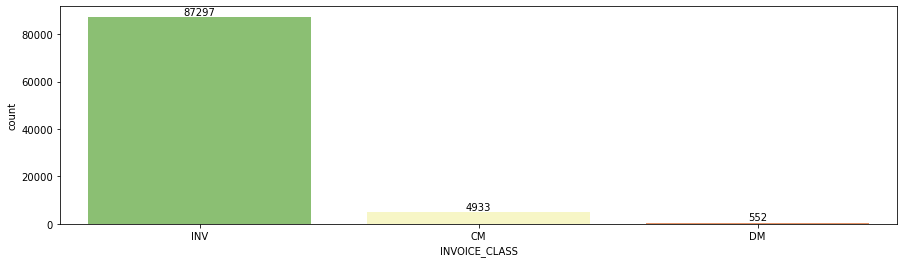

In [49]:
# Visualising the column "INVOICE_CLASS"
plt.figure(figsize=(15,4))
ax = sns.countplot(data=df, x='INVOICE_CLASS', palette='RdYlGn_r')
plt.xticks()
for label in ax.containers:
    ax.bar_label(label)
plt.show()

"INV" has the maximum number of bills in INVOICE_CLASS column.

For 'INVOICE_CURRENCY_CODE':

In [50]:
df['INVOICE_CURRENCY_CODE'].nunique()

10

In [51]:
df['INVOICE_CURRENCY_CODE'].unique()

array(['AED', 'SAR', 'USD', 'EUR', 'QAR', 'KWD', 'GBP', 'BHD', 'ZAR',
       'JOD'], dtype=object)

In [52]:
df['INVOICE_CURRENCY_CODE'].value_counts()

SAR    38491
AED    32112
USD    18367
EUR     1518
KWD     1088
QAR      611
BHD      400
GBP      134
JOD       38
ZAR       23
Name: INVOICE_CURRENCY_CODE, dtype: int64

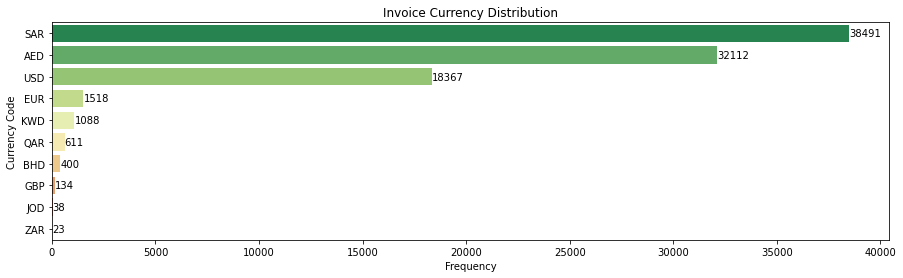

In [53]:
# Visualising the column "INVOICE_CURRENCY_CODE"
plt.figure(figsize=(15,4))
ax = sns.countplot(data=df, y='INVOICE_CURRENCY_CODE', order=df['INVOICE_CURRENCY_CODE'].value_counts().index, palette='RdYlGn_r')
for label in ax.containers:
    ax.bar_label(label)
plt.title("Invoice Currency Distribution")
plt.ylabel("Currency Code")
plt.xlabel("Frequency")
plt.show()

The most number of invoices were generated in "SAR", "AED" and "USD" currency.

For 'INVOICE_TYPE':

In [54]:
df['INVOICE_TYPE'].value_counts()

Goods        66540
Non Goods    26242
Name: INVOICE_TYPE, dtype: int64

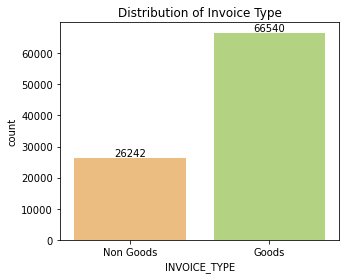

In [55]:
# Visualising the column
plt.figure(figsize=(5,4))
ax = sns.countplot(data=df, x='INVOICE_TYPE', palette='RdYlGn')
for label in ax.containers:
    ax.bar_label(label)
plt.title("Distribution of Invoice Type")
plt.show()

### Data Imbalance

In [56]:
# Checking the distribution of target column 'default'
df["Default"].value_counts(normalize= True)

1    0.656485
0    0.343515
Name: Default, dtype: float64

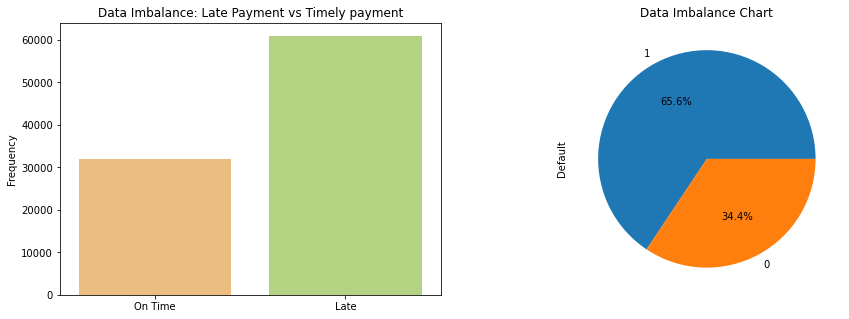

In [57]:
# ploting the "Default" column
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x='Default', data=df, palette='RdYlGn')
plt.title("Data Imbalance: Late Payment vs Timely payment")
plt.xlabel("")
plt.ylabel("Frequency")
plt.xticks((0,1), ('On Time', 'Late'))
plt.subplot(1,2,2)
#data imbalance chart
(df.Default.value_counts(normalize = True)*100).plot.pie(autopct='%1.1f%%')
plt.title("Data Imbalance Chart")
plt.show()

### Bivariate Analysis 

In [58]:
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Invoice_Month,Receipt_Month,Due_Month,Payment_Term_Days,NUM_DAYS_LATE_PAY,Default
0,WIRE,C EA Corp,2021-04-20,101018.63,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,11,4,12,58,-111,1
1,WIRE,RADW Corp,2021-01-31,48990.21,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-3,1
2,WIRE,RADW Corp,2021-01-31,41991.61,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,1,1,3,30,29,0
3,WIRE,FARO Corp,2021-01-31,41991.61,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1
4,WIRE,RADW Corp,2021-01-31,41991.61,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1


**1. Analysis on the basis of Months**

In [59]:
# Month-wise invoices due
orders_due_month =  df.groupby('Due_Month')['DUE_DATE'].count()


# Effect of monthly due on late payment rate
# Creating a pivot table to see the effects of different months on percentage of late payments
late_dues = df.groupby('Due_Month')['Default'].mean()

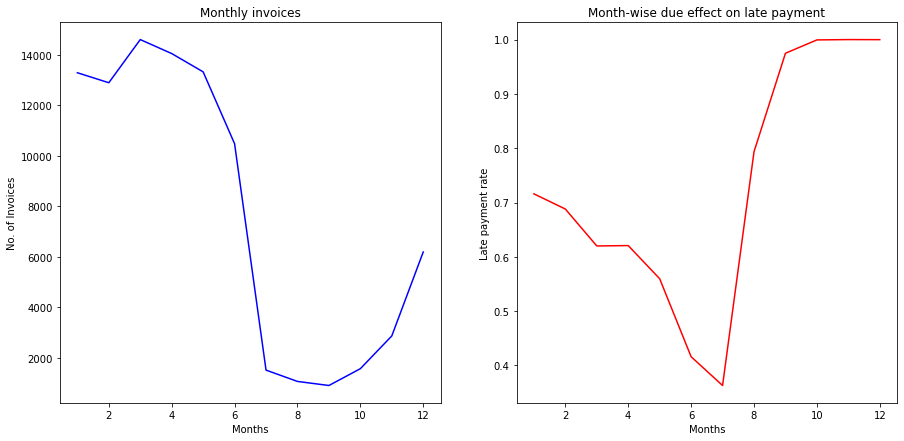

In [60]:
# Visualising the effect of month on late payment rate

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(orders_due_month, color='blue')
plt.title("Monthly invoices")
plt.xlabel("Months")
plt.ylabel("No. of Invoices")

plt.subplot(1,2,2)
plt.plot(late_dues, color='red')
plt.title("Month-wise due effect on late payment")
plt.xlabel("Months")
plt.ylabel("Late payment rate")

plt.show()

1. In the 3rd month, the number of invoices is the highest, and the late payment rate is comparatively lower than in other months with a large number of invoices.
2. Month 7 has a very low late payment rate, likely due to the fact that the number of invoices is also low.
3. In the 2nd half of the year, the late payment rate increases steeply from the 7th month onwards, even though the number of invoices is comparatively lower than in the first half of the year.

**2. Analysis on the basis of Receipt Months**

In [61]:
#Grouping the data w.r.t. the no.of reciepts recieved in each month.
order_month_receipt = df.groupby('Receipt_Month')['DUE_DATE'].count()

# Listing out all the late payments.
late_dues = df.groupby('Due_Month')['Default'].mean()

In [62]:
order_month_receipt

Receipt_Month
1    16353
2    12557
3    16522
4    13800
5    16210
6    17340
Name: DUE_DATE, dtype: int64

In [63]:
late_dues

Due_Month
1     0.715942
2     0.687999
3     0.620016
4     0.620719
5     0.559643
6     0.416070
7     0.363099
8     0.793488
9     0.974836
10    0.999367
11    1.000000
12    0.999839
Name: Default, dtype: float64

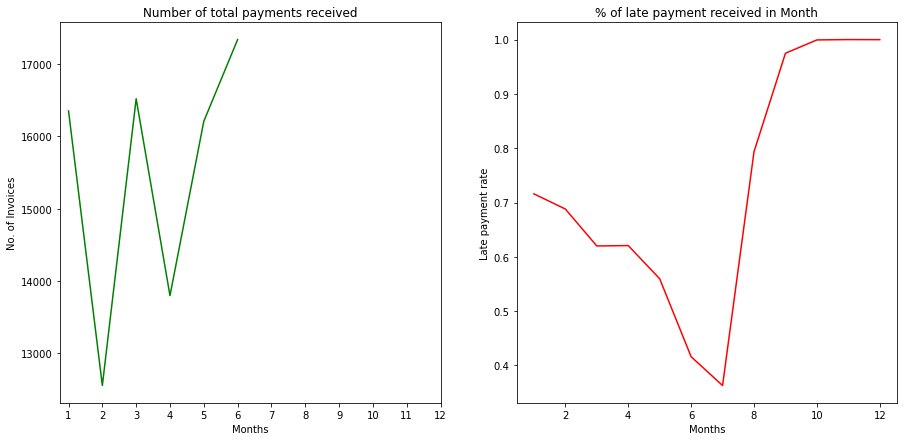

In [64]:
# Visualizing the effect of month in which the invoice is due, on the late payment rate
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(order_month_receipt, color='green')
plt.title("Number of total payments received")
plt.xticks([i for i in range(1,13,1)])
plt.xlabel("Months")
plt.ylabel("No. of Invoices")

plt.subplot(1,2,2)
plt.plot(late_dues, color='red')
plt.title("% of late payment received in Month")
plt.xlabel("Months")
plt.ylabel("Late payment rate")

plt.show()

- No payment received against any invoices from 7th month onwards even having due.

**3. Analysis on Basis of Invoice Creation Months**

In [65]:
#Number of invoices generated in a month
orders_month_created = df.groupby('Invoice_Month')['DUE_DATE'].count()

#Out of all the invoices created % of late payment
month_created = df.groupby('Invoice_Month')['Default'].mean()

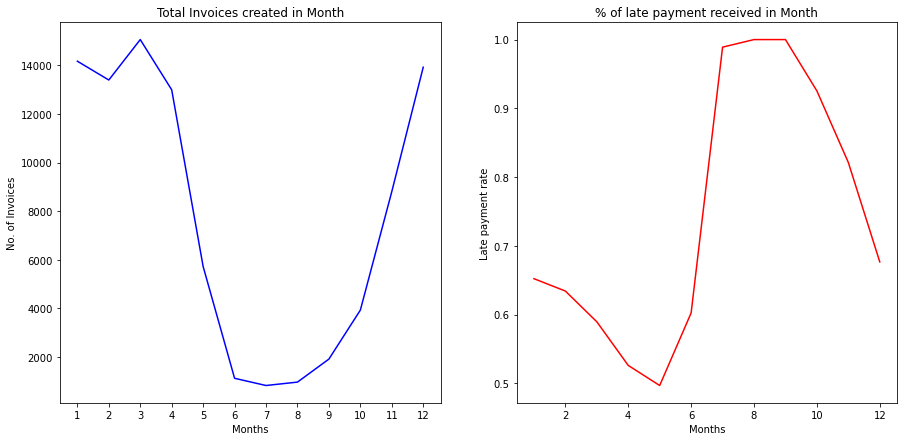

In [66]:
# Visualizing the effect of months in which the invoice is due, on the late payment rate
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(orders_month_created, color='blue')
plt.title("Total Invoices created in Month")
plt.xticks([i for i in range(1,13,1)])
plt.xlabel("Months")
plt.ylabel("No. of Invoices")

plt.subplot(1,2,2)
plt.plot(month_created, color='red')
plt.title("% of late payment received in Month")
plt.xlabel("Months")
plt.ylabel("Late payment rate")

plt.show()

1. The late payment rate decreases steadily from the 1st to the 5th month.
2. The late payment rate is very high during the 7th, 8th, and 9th months.

**4. Analysis on Basis of "USD Amount"**

In [67]:
usd_amt_late = df.pivot_table(values='USD Amount', index='Default', aggfunc=['mean', 'median', np.std]).reset_index()
usd_amt_late

,Default,mean,median,std
,,USD Amount,USD Amount,USD Amount
0,0,575346.236422,225099.13,879259.066806
1,1,518152.652465,165499.31,991649.992291


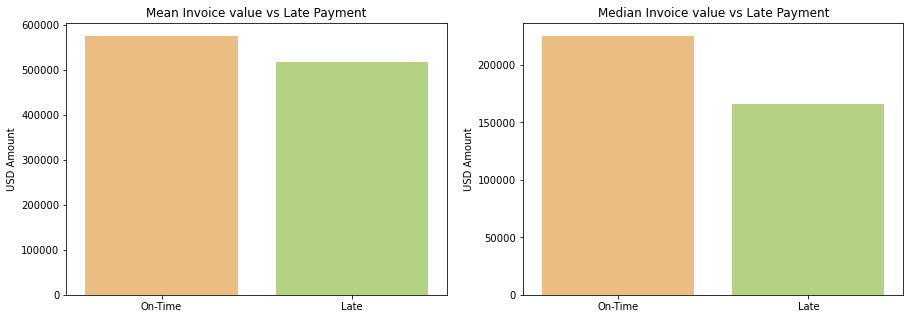

In [68]:
# Visualising the differencing between mean and median of the invoice value with respect to late payment

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.barplot(data=usd_amt_late, x='Default', y=('mean','USD Amount'), palette='RdYlGn')
plt.xticks((0,1), ('On-Time', 'Late'))
plt.title("Mean Invoice value vs Late Payment")
plt.xlabel("")
plt.ylabel("USD Amount")

plt.subplot(1,2,2)

sns.barplot(data=usd_amt_late, x='Default', y=('median','USD Amount'), palette='RdYlGn')
plt.xticks((0,1), ('On-Time', 'Late'))
plt.title("Median Invoice value vs Late Payment")
plt.xlabel("")
plt.ylabel("USD Amount")

plt.show()

The mean and median of invoice value of On-time bill payment is higher than late payment.

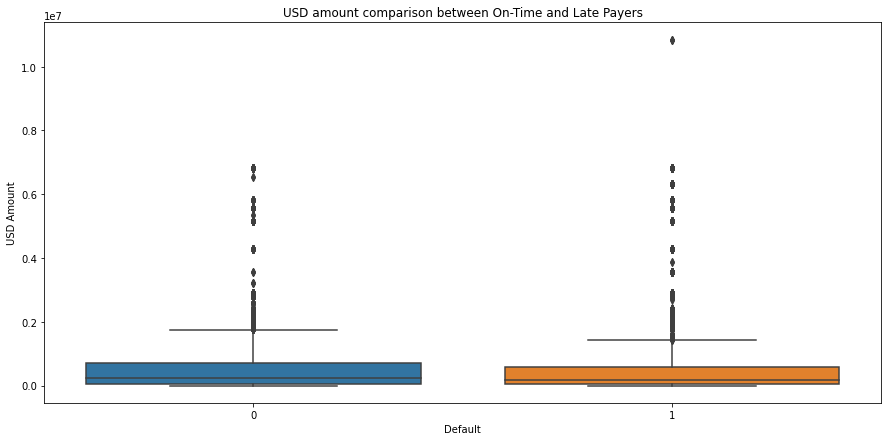

In [69]:
plt.figure(figsize=(15,7))
sns.boxplot(data = df, x='Default', y = 'USD Amount')
plt.title("USD amount comparison between On-Time and Late Payers")
plt.show()

**5. Analysis on Basis of "CUSTOMER_NAME"**

In [70]:
customer_total_orders = df.groupby('CUSTOMER_NAME')['Default'].count().sort_values(ascending=False).reset_index()
customer_total_orders_late = df.groupby('CUSTOMER_NAME')['Default'].mean().sort_values(ascending=False).reset_index()

In [71]:
# Finding the important customers (customers with more than 500 orders)
imp_cust = customer_total_orders[customer_total_orders['Default'] > 500]['CUSTOMER_NAME']
imp_cust

0     SEPH Corp
1     FARO Corp
2     PARF Corp
3     ALLI Corp
4     AREE Corp
5     DEBE Corp
6     RADW Corp
7     YOUG Corp
8     HABC Corp
9     CARR Corp
10    AL T Corp
11    VAVA Corp
12    CGR  Corp
13    REAL Corp
14    PARI Corp
15    ARAB Corp
16    LIFE Corp
17    AL S Corp
18    MCT  Corp
19    CWF  Corp
20    AL F Corp
21    CHRI Corp
Name: CUSTOMER_NAME, dtype: object

In [72]:
# Checking only important customers late payment rate
imp_cust_late = customer_total_orders_late[customer_total_orders_late['CUSTOMER_NAME'].isin(imp_cust)]
imp_cust_late

,CUSTOMER_NAME,Default
199,YOUG Corp,1.000000
246,VAVA Corp,0.937873
256,AL T Corp,0.917241
273,LIFE Corp,0.899522
287,PARI Corp,0.876153
307,PARF Corp,0.847222
309,AL S Corp,0.842788
342,CHRI Corp,0.787276
343,CARR Corp,0.786765
380,HABC Corp,0.726106


**6. Analysis on Basis of "INVOICE_CLASS"**

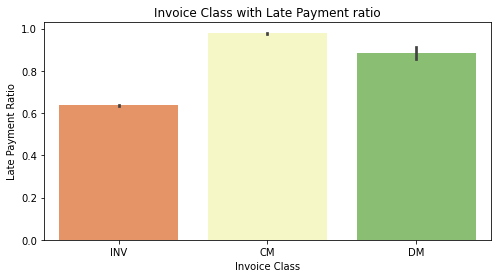

In [73]:
# Visualising the late payment ratio of each invoice class
plt.figure(figsize=(8,4))
sns.barplot(data=df, x='INVOICE_CLASS', y='Default', estimator=np.mean, palette='RdYlGn')
plt.title("Invoice Class with Late Payment ratio")
plt.xlabel("Invoice Class")
plt.ylabel("Late Payment Ratio")
plt.show()

Late payment ratio is very high for "CM" and lowest for "INV" INVOICE_CLASS.

**7. Analysis on Basis of "INVOICE_TYPE"**

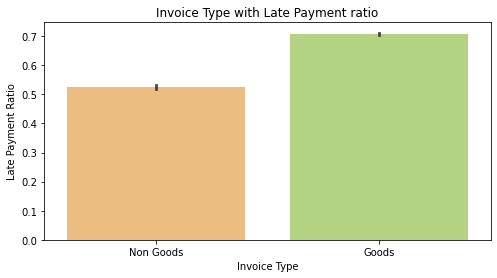

In [74]:
# Visualising the late payment ratio of each Invoice Type
plt.figure(figsize=(8,4))
sns.barplot(data=df, x='INVOICE_TYPE', y='Default', estimator=np.mean, palette='RdYlGn')
plt.title("Invoice Type with Late Payment ratio")
plt.xlabel("Invoice Type")
plt.ylabel("Late Payment Ratio")
plt.show()

Late payment ratio for Goods is higher than Non-Goods.

In [75]:
df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'RECEIPT_DATE', 'USD Amount',
       'INVOICE_CREATION_DATE', 'DUE_DATE', 'PAYMENT_TERM', 'INVOICE_CLASS',
       'INVOICE_CURRENCY_CODE', 'INVOICE_TYPE', 'Invoice_Month',
       'Receipt_Month', 'Due_Month', 'Payment_Term_Days', 'NUM_DAYS_LATE_PAY',
       'Default'],
      dtype='object')

# Feature Engineering

In [76]:
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Invoice_Month,Receipt_Month,Due_Month,Payment_Term_Days,NUM_DAYS_LATE_PAY,Default
0,WIRE,C EA Corp,2021-04-20,101018.63,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,11,4,12,58,-111,1
1,WIRE,RADW Corp,2021-01-31,48990.21,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-3,1
2,WIRE,RADW Corp,2021-01-31,41991.61,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,1,1,3,30,29,0
3,WIRE,FARO Corp,2021-01-31,41991.61,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1
4,WIRE,RADW Corp,2021-01-31,41991.61,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,12,1,1,30,-17,1


**1. Need to do Changes in "Payment_Term"**

In [77]:
df['PAYMENT_TERM'].value_counts(normalize=True)

60 Days from Inv Date                0.212649
30 Days from Inv Date                0.151107
60 Days from EOM                     0.134854
30 Days from EOM                     0.121780
Immediate Payment                    0.112101
                                       ...   
50% at 30 days and 50% at 60 days    0.000022
40 DAYS FROM EOM                     0.000022
180 DAYS FROM INV DATE               0.000011
120 Days from EOM                    0.000011
7 Days from EOM                      0.000011
Name: PAYMENT_TERM, Length: 40, dtype: float64

In [78]:
# Using cumsum() function to get cummulative sum on value_counts()
pay_term_cumsum = df['PAYMENT_TERM'].value_counts(normalize=True).cumsum()
pay_term_cumsum

60 Days from Inv Date                0.212649
30 Days from Inv Date                0.363756
60 Days from EOM                     0.498610
30 Days from EOM                     0.620390
Immediate Payment                    0.732491
                                       ...   
50% at 30 days and 50% at 60 days    0.999946
40 DAYS FROM EOM                     0.999968
180 DAYS FROM INV DATE               0.999978
120 Days from EOM                    0.999989
7 Days from EOM                      1.000000
Name: PAYMENT_TERM, Length: 40, dtype: float64

As it can be seen, around 95% of data is covered by 10 values, hence we will club the rest of the values to "others" in both datasets.

In [79]:
# Top 10 values to keep
vals_to_keep= pay_term_cumsum.index[:10]

# Clubbing the Remaining Values to "others" category
df['PAYMENT_TERM'] = df['PAYMENT_TERM'].apply(lambda x : x if x in vals_to_keep else 'others')

# Sanity Check
df['PAYMENT_TERM'].value_counts()

60 Days from Inv Date    19730
30 Days from Inv Date    14020
60 Days from EOM         12512
30 Days from EOM         11299
Immediate Payment        10401
15 Days from EOM          7533
90 Days from EOM          3893
45 Days from EOM          3831
others                    3802
45 Days from Inv Date     3550
90 Days from Inv Date     2211
Name: PAYMENT_TERM, dtype: int64

**2. Creating Dummy Variables for "PAYMENT_TERM"**

In [80]:
#Creating dummy variables for the 'PAYMENT_TERM' column, and dropping the "others" category to avoid multicollinearity and because it is not particularly important.
term_dummies= pd.get_dummies(df['PAYMENT_TERM']).drop('others', axis=1)

#Joining these Dummies to Main Dataframe i.e "df_Rec_Pay" and also dropping "PAYMENT_TERM" as we have already made dummies from it
df = df.join(term_dummies).drop('PAYMENT_TERM', axis=1 )

#Sanity Check
df.shape

(92782, 25)

**3. Creating Dummy Variables for "INVOICE_CLASS"**

In [81]:
df["INVOICE_CLASS"].value_counts()

INV    87297
CM      4933
DM       552
Name: INVOICE_CLASS, dtype: int64

In [82]:
# Creating dummy variables for the 'INVOICE_CLASS' column
class_dummies= pd.get_dummies(df['INVOICE_CLASS'])

# Joining these Dummies to Main Dataframe i.e "df_Rec_Pay" and also dropping "INVOICE_CLASS" as we have already made dummies from it
df = df.join(class_dummies).drop('INVOICE_CLASS', axis=1 )

# Sanity Check
df.shape

(92782, 27)

In [83]:
df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'RECEIPT_DATE', 'USD Amount',
       'INVOICE_CREATION_DATE', 'DUE_DATE', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'Invoice_Month', 'Receipt_Month', 'Due_Month',
       'Payment_Term_Days', 'NUM_DAYS_LATE_PAY', 'Default', '15 Days from EOM',
       '30 Days from EOM', '30 Days from Inv Date', '45 Days from EOM',
       '45 Days from Inv Date', '60 Days from EOM', '60 Days from Inv Date',
       '90 Days from EOM', '90 Days from Inv Date', 'Immediate Payment', 'CM',
       'DM', 'INV'],
      dtype='object')

# Importing "Open_Invoice_data" Dataset

In [84]:
#Reading the open invoice dataset
df_open_data = pd.read_csv("Open_Invoice_data.csv", encoding='latin1')
df_open_data.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [85]:
df_open_data.shape

(88204, 14)

From this table we observe that there are other columns as well which are not relevant to our previous data. Therefore we will:
1. Remove the columns which are not available in the recieved payment dataset.
2. 'Transaction Number' and 'Customer Account No' are unique numbers which are not relevant for our analysis.
3. We will also drop 'Local Amount' as we are having a more uniform column 'USD Amount' column.

In [86]:
df_open_data.drop(['AS_OF_DATE','Customer Type','Transaction Number', 'Transaction Date','Transaction Currency',
              'Customer Account No','Local Amount'], axis= 1, inplace= True)

In [87]:
df_open_data.shape

(88204, 7)

In [88]:
df_open_data.head()

,Customer_Name,Payment Term,Due Date,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,GIVE Corp,Immediate,21/12/2021,CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,AL J Corp,30 Days from Inv Date,03/03/2022,INVOICE,33,"2,000",2/1/2022 14:09
2,AL J Corp,30 Days from Inv Date,23/04/2022,INVOICE,-18,"2,000",3/24/2022 17:46
3,AL R Corp,15 Days from Inv Date,19/01/2022,INVOICE,76,"2,415",1/5/2022 11:49
4,ALLI Corp,30 Days from EOM,30/04/2022,INVOICE,-25,"3,800",3/3/2022 22:30


In [89]:
df_open_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Customer_Name      88204 non-null  object
 1   Payment Term       88204 non-null  object
 2   Due Date           88204 non-null  object
 3   Transaction Class  88204 non-null  object
 4   AGE                88204 non-null  int64 
 5   USD Amount         88204 non-null  object
 6   INV_CREATION_DATE  88204 non-null  object
dtypes: int64(1), object(6)
memory usage: 4.7+ MB


In [90]:
#Checking for null values
round(df_open_data.isna().sum()/len(df_open_data.index), 4)

Customer_Name        0.0
Payment Term         0.0
Due Date             0.0
Transaction Class    0.0
AGE                  0.0
USD Amount           0.0
INV_CREATION_DATE    0.0
dtype: float64

No null values present in the dataset.

In [91]:
# Changing the format of 'Due Date' and 'INV_CREATION_DATE' to pandas datetime
df_open_data['Due Date'] = pd.to_datetime(df_open_data['Due Date'])
df_open_data['INV_CREATION_DATE'] = pd.to_datetime(df_open_data['INV_CREATION_DATE'])

In [92]:
# Checking the different values present in USD Amount column
df_open_data['USD Amount'].unique()

array(['-3,088', '2,000', '2,415', ..., '-914', '12,866', '18,118'],
      dtype=object)

In [93]:
# It is in actual Integer value so have convert it from Object to Int
# Changing the datatype of USD Amount
df_open_data['USD Amount'] = df_open_data['USD Amount'].apply(lambda x: x.replace(",", ""))
df_open_data['USD Amount'] = df_open_data['USD Amount'].astype(int)

In [94]:
# Checking the USD Amount column again
df_open_data['USD Amount']

0        -3088
1         2000
2         2000
3         2415
4         3800
         ...  
88199    -1199
88200     -914
88201    12866
88202    18118
88203    18499
Name: USD Amount, Length: 88204, dtype: int32

There are negative values present in the column, hence it is safe to remove negative and 0 values. As we also removed it from Received Payments Dataset so we need to remove it.

In [95]:
#Keeping the values above 0 for USD Amount column
df_open_data = df_open_data[df_open_data['USD Amount']>0]

In [96]:
#Sanity Check
df_open_data['USD Amount'].describe().round()

count      79516.0
mean        5918.0
std        40562.0
min            1.0
25%           77.0
50%          506.0
75%         2733.0
max      5978000.0
Name: USD Amount, dtype: float64

In [97]:
df_open_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79516 entries, 1 to 88203
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Customer_Name      79516 non-null  object        
 1   Payment Term       79516 non-null  object        
 2   Due Date           79516 non-null  datetime64[ns]
 3   Transaction Class  79516 non-null  object        
 4   AGE                79516 non-null  int64         
 5   USD Amount         79516 non-null  int32         
 6   INV_CREATION_DATE  79516 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int32(1), int64(1), object(3)
memory usage: 4.5+ MB


All the columns are in correct format now.

# Feature Engineering

In [98]:
df_open_data.head()

,Customer_Name,Payment Term,Due Date,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
1,AL J Corp,30 Days from Inv Date,2022-03-03,INVOICE,33,2000,2022-02-01 14:09:00
2,AL J Corp,30 Days from Inv Date,2022-04-23,INVOICE,-18,2000,2022-03-24 17:46:00
3,AL R Corp,15 Days from Inv Date,2022-01-19,INVOICE,76,2415,2022-01-05 11:49:00
4,ALLI Corp,30 Days from EOM,2022-04-30,INVOICE,-25,3800,2022-03-03 22:30:00
5,ALLI Corp,30 Days from EOM,2022-04-30,INVOICE,-25,1264,2022-03-03 22:30:00


In [99]:
df_open_data.columns

Index(['Customer_Name', 'Payment Term', 'Due Date', 'Transaction Class', 'AGE',
       'USD Amount', 'INV_CREATION_DATE'],
      dtype='object')

**1. Need to do Changes in "Payment_Term"**

In [100]:
#Maintaining the same levels as in the received payment dataset:
#`vals_to_keep` is a variable containing the top 10 payment terms.
df_open_data['Payment Term'] = df_open_data['Payment Term'].apply(lambda x: x if x in vals_to_keep else 'others')

df_open_data['Payment Term'].value_counts()

30 Days from Inv Date    18328
60 Days from Inv Date    17599
Immediate Payment        16202
60 Days from EOM          8170
others                    5385
30 Days from EOM          5324
90 Days from EOM          2595
90 Days from Inv Date     2429
45 Days from Inv Date     1533
15 Days from EOM          1097
45 Days from EOM           854
Name: Payment Term, dtype: int64

In [101]:
# Creating dummy variables for the column as we already did with "df_Rec_Pay"
term_dummies_open = pd.get_dummies(df_open_data['Payment Term']).drop('others', axis=1)

# Merging the dummies dataframe into df_open_data and removing the 'Payment Term' column
df_open_data = df_open_data.join(term_dummies_open).drop('Payment Term', axis=1)
df_open_data.head()

,Customer_Name,Due Date,Transaction Class,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment
1,AL J Corp,2022-03-03,INVOICE,33,2000,2022-02-01 14:09:00,0,0,1,0,0,0,0,0,0,0
2,AL J Corp,2022-04-23,INVOICE,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0
3,AL R Corp,2022-01-19,INVOICE,76,2415,2022-01-05 11:49:00,0,0,0,0,0,0,0,0,0,0
4,ALLI Corp,2022-04-30,INVOICE,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0
5,ALLI Corp,2022-04-30,INVOICE,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0


**2. Need to do Changes in "Transaction Class"**

In [102]:
# Checking the levels in the column
df_open_data['Transaction Class'].value_counts()

INVOICE       78251
DEBIT NOTE     1265
Name: Transaction Class, dtype: int64

In [103]:
# Replacing "INVOICE" with "INV" and "DEBIT NOTE" WITH "DM" as same as "INOVICE CLASS" from "df_Rec_Pay"
df_open_data['Transaction Class'] = df_open_data['Transaction Class'].map(lambda x: 'INV' if x=='INVOICE' else 'DM')

In [104]:
# Creating dummy variables for the column "Transaction Class"
tc = pd.get_dummies(df_open_data['Transaction Class'])

# Adding the dummy variables to main dataset and dropping the Transaction Class column
df_open_data = df_open_data.join(tc).drop('Transaction Class', axis=1)

# Adding 'CM' level to the "df_open_data" dataset same as "df_Rec_Pay"
df_open_data['CM'] = 0

In [105]:
# Checking the dataframe
df_open_data.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM
1,AL J Corp,2022-03-03,33,2000,2022-02-01 14:09:00,0,0,1,0,0,0,0,0,0,0,0,1,0
2,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0
3,AL R Corp,2022-01-19,76,2415,2022-01-05 11:49:00,0,0,0,0,0,0,0,0,0,0,0,1,0
4,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0
5,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0


**Checking Columns of Both Dataframe**

In [106]:
df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'RECEIPT_DATE', 'USD Amount',
       'INVOICE_CREATION_DATE', 'DUE_DATE', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'Invoice_Month', 'Receipt_Month', 'Due_Month',
       'Payment_Term_Days', 'NUM_DAYS_LATE_PAY', 'Default', '15 Days from EOM',
       '30 Days from EOM', '30 Days from Inv Date', '45 Days from EOM',
       '45 Days from Inv Date', '60 Days from EOM', '60 Days from Inv Date',
       '90 Days from EOM', '90 Days from Inv Date', 'Immediate Payment', 'CM',
       'DM', 'INV'],
      dtype='object')

In [107]:
df_open_data.columns

Index(['Customer_Name', 'Due Date', 'AGE', 'USD Amount', 'INV_CREATION_DATE',
       '15 Days from EOM', '30 Days from EOM', '30 Days from Inv Date',
       '45 Days from EOM', '45 Days from Inv Date', '60 Days from EOM',
       '60 Days from Inv Date', '90 Days from EOM', '90 Days from Inv Date',
       'Immediate Payment', 'DM', 'INV', 'CM'],
      dtype='object')

# Customer Segmentation

**Recommendation:**
Customer-level attributes could also be important independent variables to be included in the model. A customer-level attribute can be determined via customer segmentation. You have to segment your customers based on *two derived variables*: **the average payment time in days** for a customer and the **standard deviation for the payment time**. Using clustering techniques would result in a few distinct clusters of customers, which can be used as an input variable for the ML model.

In [108]:
df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Invoice_Month,Receipt_Month,Due_Month,Payment_Term_Days,NUM_DAYS_LATE_PAY,Default,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,CM,DM,INV
0,WIRE,C EA Corp,2021-04-20,101018.63,2020-11-02,2020-12-30,AED,Non Goods,11,4,12,58,-111,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,WIRE,RADW Corp,2021-01-31,48990.21,2020-12-29,2021-01-28,SAR,Non Goods,12,1,1,30,-3,1,0,0,1,0,0,0,0,0,0,0,0,0,1
2,WIRE,RADW Corp,2021-01-31,41991.61,2021-01-30,2021-03-01,SAR,Non Goods,1,1,3,30,29,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,WIRE,FARO Corp,2021-01-31,41991.61,2020-12-15,2021-01-14,SAR,Non Goods,12,1,1,30,-17,1,0,0,1,0,0,0,0,0,0,0,0,0,1
4,WIRE,RADW Corp,2021-01-31,41991.61,2020-12-15,2021-01-14,SAR,Non Goods,12,1,1,30,-17,1,0,0,1,0,0,0,0,0,0,0,0,0,1


**1. Creating New Column "act_days_for_pay"**

In [109]:
# Creating a new column to show actual number of days taken to make the payment after invoice generation
df['act_days_for_pay'] = (df['RECEIPT_DATE'] - df['INVOICE_CREATION_DATE']).dt.days

**2. Creating 2 Clusters of 2 Columns (i.e. 'CUSTOMER_NAME', 'act_days_for_pay') with Mean and Standard Deviation**

In [110]:
# Calculating customer wise average days for payment
cust_seg1= df.groupby('CUSTOMER_NAME')['act_days_for_pay'].mean()
cust_seg1 = cust_seg1.to_frame()
cust_seg1.reset_index
cust_seg1.rename(columns={'act_days_for_pay': 'Avg days for payment'}, inplace=True)
cust_seg1.head()

,Avg days for payment
CUSTOMER_NAME,
3D D Corp,24.395349
6TH Corp,40.666667
A3 D Corp,45.400000
ABC Corp,16.000000
ABDU Corp,76.906250


In [111]:
# Calculating the standard deviation for customer wise payment days
cust_seg2 = df.groupby('CUSTOMER_NAME')['act_days_for_pay'].std()
cust_seg2 = cust_seg2.to_frame()
cust_seg2.reset_index
cust_seg2.rename(columns={'act_days_for_pay': 'Std deviation for payment'}, inplace=True)
cust_seg2.head()

,Std deviation for payment
CUSTOMER_NAME,
3D D Corp,13.040449
6TH Corp,7.952987
A3 D Corp,52.581366
ABC Corp,0.000000
ABDU Corp,54.919326


In [112]:
# Merging the above two dataframes
cust_seg = pd.merge(cust_seg1, cust_seg2, how='inner', on='CUSTOMER_NAME')

# Checking the head
cust_seg.head()

,Avg days for payment,Std deviation for payment
CUSTOMER_NAME,,
3D D Corp,24.395349,13.040449
6TH Corp,40.666667,7.952987
A3 D Corp,45.400000,52.581366
ABC Corp,16.000000,0.000000
ABDU Corp,76.906250,54.919326


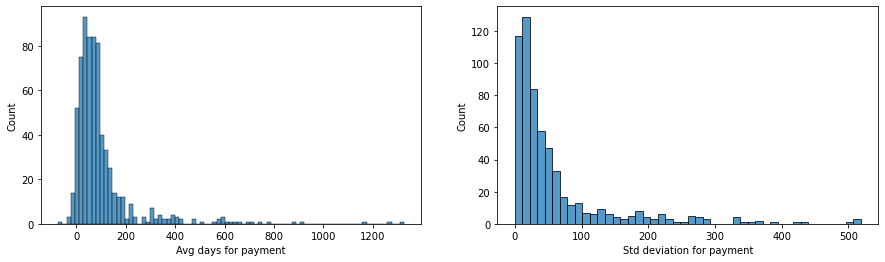

In [113]:
# Visualising the cust_seg dataframe
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
sns.histplot(cust_seg['Avg days for payment'])

plt.subplot(1,2,2)
sns.histplot(cust_seg['Std deviation for payment'])

plt.show()

From the above plots we can see that the data is not normalized, hence need to do scaling.

**3. Scaling**

In [114]:
scaler=StandardScaler()
cust_seg[['Avg days for payment', 'Std deviation for payment']] = scaler.fit_transform(cust_seg[['Avg days for payment', 'Std deviation for payment']])

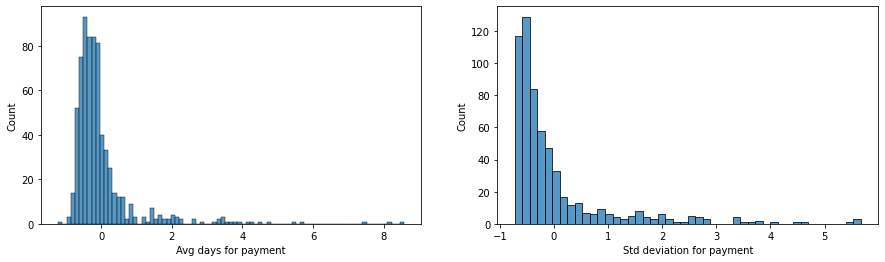

In [115]:
# Visualising the data again
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
sns.histplot(cust_seg['Avg days for payment'])

plt.subplot(1,2,2)
sns.histplot(cust_seg['Std deviation for payment'])

plt.show()

In [116]:
# resetting the index
cust_seg.reset_index(inplace=True)

# Checking the null values if present
round(cust_seg.isna().sum()/len(cust_seg.index), 4)

CUSTOMER_NAME                0.0000
Avg days for payment         0.0000
Std deviation for payment    0.1248
dtype: float64

In [117]:
# Replacing the null values for Std deviation for payment with 0
cust_seg['Std deviation for payment'].fillna(0,inplace=True)

In [118]:
# copying the cust_seg data for clustering into new dataframe
cluster_df = cust_seg.copy()
cluster_df.head()

,CUSTOMER_NAME,Avg days for payment,Std deviation for payment
0,3D D Corp,-0.534418,-0.562984
1,6TH Corp,-0.420561,-0.625713
2,A3 D Corp,-0.387440,-0.075443
3,ABC Corp,-0.593163,-0.723774
4,ABDU Corp,-0.166979,-0.046616


In [119]:
#dropping customer_name for clustering
cluster_df.drop('CUSTOMER_NAME',axis=1,inplace=True)
cluster_df.head()

,Avg days for payment,Std deviation for payment
0,-0.534418,-0.562984
1,-0.420561,-0.625713
2,-0.387440,-0.075443
3,-0.593163,-0.723774
4,-0.166979,-0.046616


**4. Clustering**

In [120]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=42)
kmeans.fit(cluster_df)
kmeans.cluster_centers_

array([[-0.28942961, -0.32373928],
       [ 1.84731224,  3.39426791],
       [ 0.4292466 ,  1.05132713],
       [ 4.66646237,  0.44520486]])

**5. Finding Optimal Numbers of Clusters**

In [121]:
# silhouette analysis
cluster_range = [2, 3, 4, 5, 6, 7, 8]

for cluster in cluster_range:

    # intialise kmeans
    kmeans = KMeans(n_clusters=cluster, max_iter=50, random_state=42)
    kmeans.fit(cluster_df)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(cluster_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(cluster, silhouette_avg))

For n_clusters=2, the silhouette score is 0.7558639609611041
For n_clusters=3, the silhouette score is 0.7350736202143917
For n_clusters=4, the silhouette score is 0.6183039428009872
For n_clusters=5, the silhouette score is 0.6209695755402551
For n_clusters=6, the silhouette score is 0.4036140705319077
For n_clusters=7, the silhouette score is 0.4078357624029187
For n_clusters=8, the silhouette score is 0.41568567013274155


From the above results, we can see that for 3 clusters, the silhouette score is decent. Hence selecting n_clusters as 3.

In [122]:
# final model with n_clusters=3
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=42)
kmeans.fit(cluster_df)

KMeans(max_iter=50, n_clusters=3, random_state=42)

In [123]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [124]:
# Assigning labels to the cust_seg dataframe
cust_seg['cluster_id'] = kmeans.labels_
cust_seg.head()

,CUSTOMER_NAME,Avg days for payment,Std deviation for payment,cluster_id
0,3D D Corp,-0.534418,-0.562984,2
1,6TH Corp,-0.420561,-0.625713,2
2,A3 D Corp,-0.387440,-0.075443,2
3,ABC Corp,-0.593163,-0.723774,2
4,ABDU Corp,-0.166979,-0.046616,2


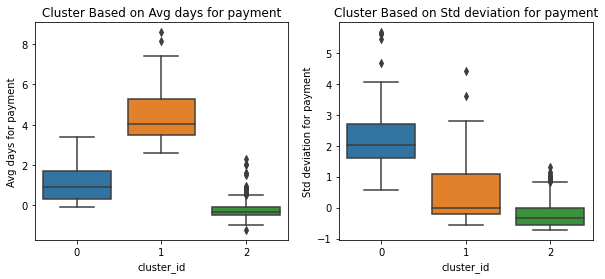

In [125]:
# Plotting box plot based on clusters
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='cluster_id', y='Avg days for payment', data=cust_seg)
plt.title("Cluster Based on Avg days for payment")


plt.subplot(1,2,2)
sns.boxplot(x='cluster_id', y='Std deviation for payment', data=cust_seg)
plt.title("Cluster Based on Std deviation for payment")
plt.show()

- '1' Cluster -- Prolonged Invoice Payment

- '2' Cluster -- Early Invoice Payment

- '0' Cluster -- Medium Invoice Payment

In [126]:
# Dropping the 'Avg days for payment' and 'Std deviation for payment' columns to prepare 
#for merging this dataset with the open invoice dataset, enabling the assignment of cluster IDs to each customer.
cust_seg.drop(['Avg days for payment', 'Std deviation for payment'], axis=1, inplace=True)

In [127]:
# Creating a copy
cust_dict = cust_seg.copy()

In [128]:
# Renaming the column
cust_dict.rename(columns={'CUSTOMER_NAME':'Customer_Name'}, inplace=True)
cust_dict.head()

,Customer_Name,cluster_id
0,3D D Corp,2
1,6TH Corp,2
2,A3 D Corp,2
3,ABC Corp,2
4,ABDU Corp,2


In [129]:
# Setting the 'Customer_Name' as index
cust_dict.set_index('Customer_Name')

,cluster_id
Customer_Name,
3D D Corp,2
6TH Corp,2
A3 D Corp,2
ABC Corp,2
ABDU Corp,2
...,...
YOUS Corp,2
ZAHR Corp,2
ZAIN Corp,2


Text(0.5, 1.0, 'Customer Segment Distribution Chart')

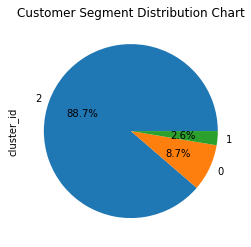

In [130]:
(cust_dict.cluster_id.value_counts(normalize = True)*100).plot.pie(autopct='%1.1f%%')
plt.title("Customer Segment Distribution Chart")

Where

- '1' Cluster -- Prolonged Invoice Payment

- '2' Cluster -- Early Invoice Payment

- '0' Cluster -- Medium Invoice Payment

- From the above we can see that Early customers comprise of 88.7% of customers whereas medium and prolonged payers are 11.3% in total

**7. Merging Cluster Number Column with main Dataframe**

In [131]:
# Merging rec_pay_data and cust_deg to add clustering index
merged_df = pd.merge(df, cust_seg, how='inner', on='CUSTOMER_NAME')
merged_df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Invoice_Month,Receipt_Month,Due_Month,Payment_Term_Days,NUM_DAYS_LATE_PAY,Default,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,CM,DM,INV,act_days_for_pay,cluster_id
0,WIRE,C EA Corp,2021-04-20,101018.63,2020-11-02,2020-12-30,AED,Non Goods,11,4,12,58,-111,1,0,1,0,0,0,0,0,0,0,0,0,0,1,169,2
1,WIRE,C EA Corp,2021-05-19,2859.09,2021-04-07,2021-05-30,AED,Non Goods,4,5,5,53,11,0,0,1,0,0,0,0,0,0,0,0,0,0,1,42,2
2,WIRE,C EA Corp,2021-02-20,10.58,2020-11-26,2020-12-26,AED,Non Goods,11,2,12,30,-56,1,0,0,1,0,0,0,0,0,0,0,0,0,1,86,2
3,WIRE,RADW Corp,2021-01-31,48990.21,2020-12-29,2021-01-28,SAR,Non Goods,12,1,1,30,-3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,33,2
4,WIRE,RADW Corp,2021-01-31,41991.61,2021-01-30,2021-03-01,SAR,Non Goods,1,1,3,30,29,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2


In [132]:
# checking null values for clusters
merged_df['cluster_id'].isnull().sum()

0

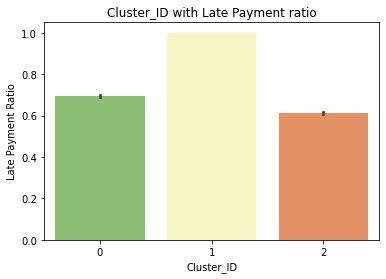

In [133]:
sns.barplot(data=merged_df, x='cluster_id', y='Default', estimator=np.mean, palette='RdYlGn_r')
plt.title("Cluster_ID with Late Payment ratio")
plt.xlabel("Cluster_ID")
plt.ylabel("Late Payment Ratio")
plt.show()

In [134]:
merged_df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'RECEIPT_DATE', 'USD Amount',
       'INVOICE_CREATION_DATE', 'DUE_DATE', 'INVOICE_CURRENCY_CODE',
       'INVOICE_TYPE', 'Invoice_Month', 'Receipt_Month', 'Due_Month',
       'Payment_Term_Days', 'NUM_DAYS_LATE_PAY', 'Default', '15 Days from EOM',
       '30 Days from EOM', '30 Days from Inv Date', '45 Days from EOM',
       '45 Days from Inv Date', '60 Days from EOM', '60 Days from Inv Date',
       '90 Days from EOM', '90 Days from Inv Date', 'Immediate Payment', 'CM',
       'DM', 'INV', 'act_days_for_pay', 'cluster_id'],
      dtype='object')

# Steps for Model Builidng

## 1. Data Preparation

In [135]:
# Creating a new dataframe with important variables for model building
reg_df = merged_df[['USD Amount','INVOICE_CREATION_DATE', '15 Days from EOM', '30 Days from EOM',
                    '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date', '60 Days from EOM',
                    '60 Days from Inv Date', '90 Days from EOM', '90 Days from Inv Date', 'Immediate Payment',
                    'DM', 'INV', 'CM','cluster_id']]
reg_df.head()

,USD Amount,INVOICE_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id
0,101018.63,2020-11-02,0,1,0,0,0,0,0,0,0,0,0,1,0,2
1,2859.09,2021-04-07,0,1,0,0,0,0,0,0,0,0,0,1,0,2
2,10.58,2020-11-26,0,0,1,0,0,0,0,0,0,0,0,1,0,2
3,48990.21,2020-12-29,0,0,1,0,0,0,0,0,0,0,0,1,0,2
4,41991.61,2021-01-30,0,0,1,0,0,0,0,0,0,0,0,1,0,2


In [136]:
# Identify columns with boolean values
boolean_columns = reg_df.select_dtypes(include=bool).columns

# Convert boolean columns to 0 and 1
reg_df[boolean_columns] = reg_df[boolean_columns].astype(int)

reg_df.head()

,USD Amount,INVOICE_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id
0,101018.63,2020-11-02,0,1,0,0,0,0,0,0,0,0,0,1,0,2
1,2859.09,2021-04-07,0,1,0,0,0,0,0,0,0,0,0,1,0,2
2,10.58,2020-11-26,0,0,1,0,0,0,0,0,0,0,0,1,0,2
3,48990.21,2020-12-29,0,0,1,0,0,0,0,0,0,0,0,1,0,2
4,41991.61,2021-01-30,0,0,1,0,0,0,0,0,0,0,0,1,0,2


In [137]:
# Creating Invoice_Month column and dropping INVOICE_CREATION_DATE
reg_df['Invoice_Month'] = reg_df['INVOICE_CREATION_DATE'].dt.month
reg_df.drop('INVOICE_CREATION_DATE',axis=1,inplace= True)
reg_df.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
0,101018.63,0,1,0,0,0,0,0,0,0,0,0,1,0,2,11
1,2859.09,0,1,0,0,0,0,0,0,0,0,0,1,0,2,4
2,10.58,0,0,1,0,0,0,0,0,0,0,0,1,0,2,11
3,48990.21,0,0,1,0,0,0,0,0,0,0,0,1,0,2,12
4,41991.61,0,0,1,0,0,0,0,0,0,0,0,1,0,2,1


In [138]:
reg_df.shape

(92782, 16)

In [139]:
# Open Invoice dataset
open_reg_df = df_open_data[['Due Date','USD Amount', 'INV_CREATION_DATE', '15 Days from EOM', '30 Days from EOM',
                         '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date', '60 Days from EOM',
                         '60 Days from Inv Date', '90 Days from EOM', '90 Days from Inv Date', 'Immediate Payment',
                         'DM', 'INV', 'CM','AGE']]
open_reg_df.head()

,Due Date,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,AGE
1,2022-03-03,2000,2022-02-01 14:09:00,0,0,1,0,0,0,0,0,0,0,0,1,0,33
2,2022-04-23,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,-18
3,2022-01-19,2415,2022-01-05 11:49:00,0,0,0,0,0,0,0,0,0,0,0,1,0,76
4,2022-04-30,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,-25
5,2022-04-30,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,-25


In [140]:
# Identify columns with boolean values
boolean_columns = open_reg_df.select_dtypes(include=bool).columns

# Convert boolean columns to 0 and 1
open_reg_df[boolean_columns] = open_reg_df[boolean_columns].astype(int)

open_reg_df.head()

,Due Date,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,AGE
1,2022-03-03,2000,2022-02-01 14:09:00,0,0,1,0,0,0,0,0,0,0,0,1,0,33
2,2022-04-23,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,-18
3,2022-01-19,2415,2022-01-05 11:49:00,0,0,0,0,0,0,0,0,0,0,0,1,0,76
4,2022-04-30,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,-25
5,2022-04-30,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,-25


In [141]:
# Creating Invoice_Month column and dropping INV_CREATION_DATE
open_reg_df['Invoice_Month'] = open_reg_df['INV_CREATION_DATE'].dt.month
open_reg_df.drop('INV_CREATION_DATE',axis=1,inplace= True)
open_reg_df.head()

,Due Date,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,AGE,Invoice_Month
1,2022-03-03,2000,0,0,1,0,0,0,0,0,0,0,0,1,0,33,2
2,2022-04-23,2000,0,0,1,0,0,0,0,0,0,0,0,1,0,-18,3
3,2022-01-19,2415,0,0,0,0,0,0,0,0,0,0,0,1,0,76,1
4,2022-04-30,3800,0,1,0,0,0,0,0,0,0,0,0,1,0,-25,3
5,2022-04-30,1264,0,1,0,0,0,0,0,0,0,0,0,1,0,-25,3


In [142]:
# Creating Due_Month column and dropping Due Date
open_reg_df['Due_Month'] = open_reg_df['Due Date'].dt.month
open_reg_df.drop('Due Date',axis=1,inplace= True)
open_reg_df.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,AGE,Invoice_Month,Due_Month
1,2000,0,0,1,0,0,0,0,0,0,0,0,1,0,33,2,3
2,2000,0,0,1,0,0,0,0,0,0,0,0,1,0,-18,3,4
3,2415,0,0,0,0,0,0,0,0,0,0,0,1,0,76,1,1
4,3800,0,1,0,0,0,0,0,0,0,0,0,1,0,-25,3,4
5,1264,0,1,0,0,0,0,0,0,0,0,0,1,0,-25,3,4


In [143]:
# Checking columns for both datasets
reg_df.columns

Index(['USD Amount', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'DM', 'INV', 'CM',
       'cluster_id', 'Invoice_Month'],
      dtype='object')

In [144]:
open_reg_df.columns

Index(['USD Amount', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'DM', 'INV', 'CM', 'AGE',
       'Invoice_Month', 'Due_Month'],
      dtype='object')

## 2. Train Test Split 

In [145]:
# Feature variables X
X = reg_df.copy()
X.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
0,101018.63,0,1,0,0,0,0,0,0,0,0,0,1,0,2,11
1,2859.09,0,1,0,0,0,0,0,0,0,0,0,1,0,2,4
2,10.58,0,0,1,0,0,0,0,0,0,0,0,1,0,2,11
3,48990.21,0,0,1,0,0,0,0,0,0,0,0,1,0,2,12
4,41991.61,0,0,1,0,0,0,0,0,0,0,0,1,0,2,1


In [146]:
# Target variable y
y = merged_df['Default']
y.head()

0    1
1    0
2    1
3    1
4    0
Name: Default, dtype: int32

In [147]:
# Splitting into train and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=42)
X_train.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
48066,327839.47,0,1,0,0,0,0,0,0,0,0,0,1,0,2,2
77829,148200.00,0,0,1,0,0,0,0,0,0,0,0,1,0,2,1
39524,1095532.32,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3
83240,150973.68,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2
65588,25690.87,1,0,0,0,0,0,0,0,0,0,0,1,0,2,4


## 3. Feature Scaling

In [148]:
X_train.shape

(64947, 16)

In [149]:
# Feature scaling for USD amount
scaler = StandardScaler()
X_train['USD Amount'] = scaler.fit_transform(X_train[['USD Amount']])
X_train.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
48066,-0.219005,0,1,0,0,0,0,0,0,0,0,0,1,0,2,2
77829,-0.408315,0,0,1,0,0,0,0,0,0,0,0,1,0,2,1
39524,0.590015,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3
83240,-0.405392,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2
65588,-0.537419,1,0,0,0,0,0,0,0,0,0,0,1,0,2,4


In [150]:
X_train.describe()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Invoice_Month
count,6.494700e+04,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000,64947.000000
mean,-3.519544e-17,0.081405,0.121838,0.151077,0.040910,0.038601,0.136434,0.212219,0.041295,0.024050,0.111337,0.005759,0.941383,0.052858,0.941167,5.466965
std,1.000008e+00,0.273458,0.327101,0.358127,0.198084,0.192643,0.343252,0.408882,0.198974,0.153207,0.314551,0.075667,0.234908,0.223753,0.997396,4.077129
min,-5.644905e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-5.222024e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
50%,-3.626180e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000
75%,6.739994e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,10.000000
max,1.086941e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,12.000000


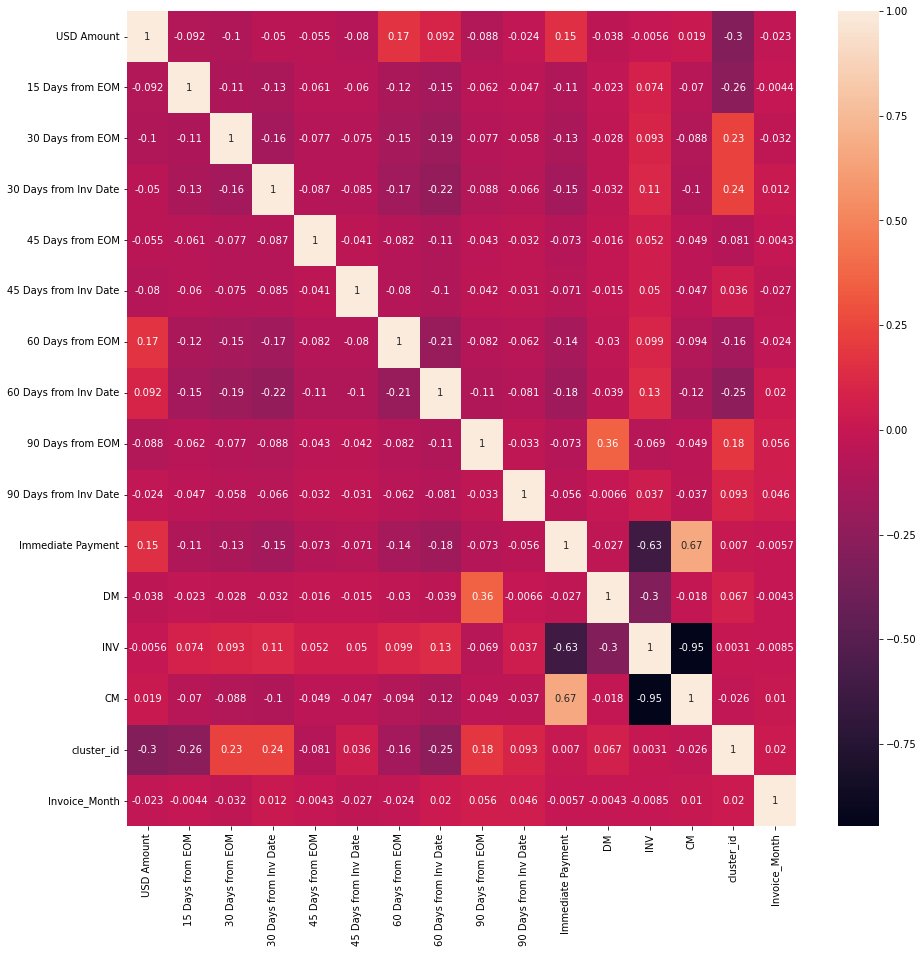

In [151]:
# Plotting heat map of X_train dataset
plt.figure(figsize=(15,15))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

- "CM" & "INV", "INV" & "Immediate Payment", "DM" & "90 days" from "EOM" has high multicollinearity, hence dropping these columns.

In [152]:
X_train.drop(['CM', 'INV', 'DM'], axis=1, inplace=True)
X_test.drop(['CM', 'INV', 'DM'], axis=1, inplace=True)

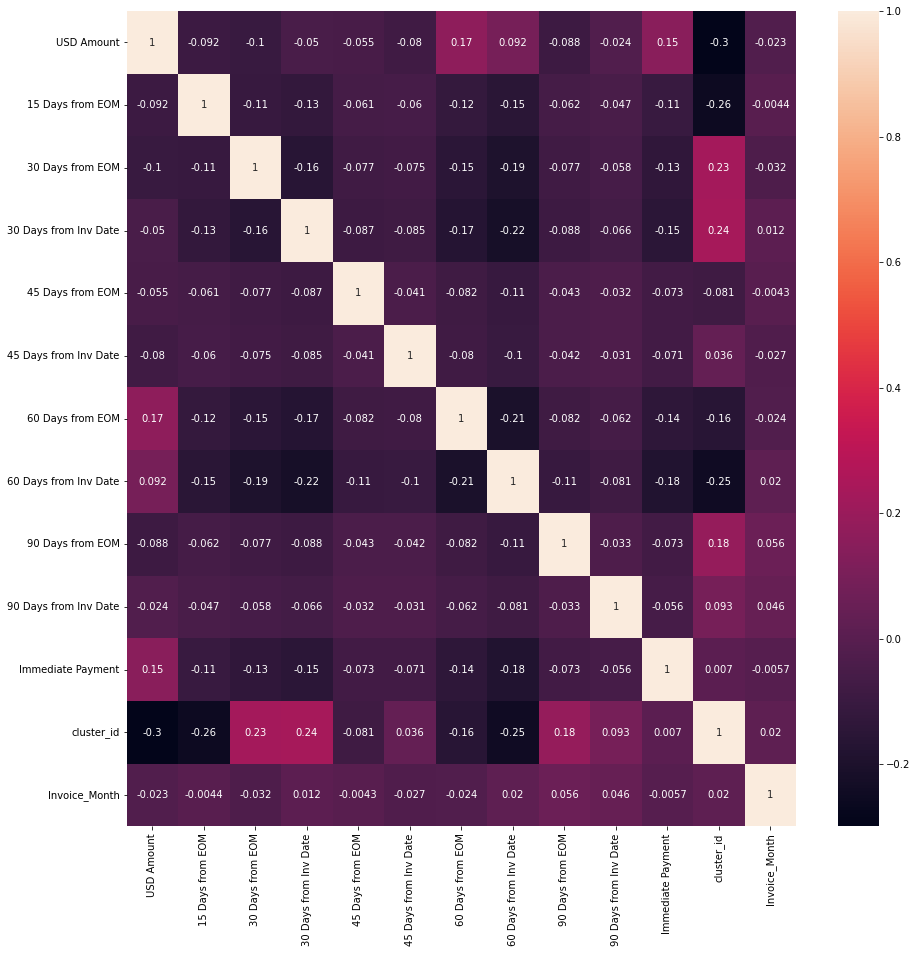

In [153]:
# Plotting heat map of X_train dataset again
plt.figure(figsize=(15,15))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

Now the data has no high multicollinearity. Going ahead with model building

## 4. Model Building - Logisitic Regression

**1st Model**

In [154]:
X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res=logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Default   No. Observations:                64947
Model:                            GLM   Df Residuals:                    64933
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30170.
Date:                Sat, 08 Jun 2024   Deviance:                       60339.
Time:                        16:48:55   Pearson chi2:                 6.34e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3012
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.7495      0.050     15.124      0.000       0.652       0.847
USD Amount               -0.1054      0.012     -8.748      0.000      -0.129      -0.082
15 Days from EOM          2.6146      0.108     24.267      0.000       2.403       2.826
30 Days from EOM         -2.2548      0.052    -42.950      0.000      -2.358      -2.152
30 Days from Inv Date     0.2638      0.052      5.102      0.000       0.162       0.365
45 Days from EOM          0.3968      0.070      5.704      0.000       0.260       0.533
45 Days from Inv Date    -0.3347      0.063     -5.338      0.000      -0.458      -0.212
60 Days from EOM         -2.2158      0.053    -41.704      0.000      -2.320      -2.112
60 Days from Inv Date    -0.2641      0.051     -5.219      0.000      -0.363      -0.165
90 Days from EOM         -0.4898      0.062     -7.953      0.000      -0.611      -0.369
90 Days from Inv Date    -1.0483      0.069    -15.203      0.000      -1.183      -0.913
Immediate Payment         3.0618      0.103     29.634      0.000       2.859       3.264
cluster_id               -0.1355      0.012    -11.123      0.000      -0.159      -0.112
Invoice_Month             0.0978      0.003     38.542      0.000       0.093       0.103
=========================================================================================
"""

**Checking VIF**

In [155]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,Invoice_Month,2.67
11,cluster_id,2.60
3,30 Days from Inv Date,1.66
2,30 Days from EOM,1.52
7,60 Days from Inv Date,1.45
10,Immediate Payment,1.36
6,60 Days from EOM,1.31
8,90 Days from EOM,1.25
0,USD Amount,1.20
1,15 Days from EOM,1.14


**Both the "p-value" and "VIF" are in acceptable range, hence going ahead with this model.**

In [156]:
# Predicted values for train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

48066    0.174002
77829    0.707480
39524    0.671867
83240    0.673433
65588    0.971832
79685    0.804979
49356    0.845763
36627    0.679011
29368    0.410519
48907    0.674191
dtype: float64

In [157]:
# Reshaping the array
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.17400188, 0.70747994, 0.6718666 , 0.67343304, 0.9718321 ,
       0.80497852, 0.84576285, 0.67901052, 0.41051948, 0.67419072])

In [158]:
# Creating a dataframe for predicted values
y_pred = pd.DataFrame({'default':y_train.values, 'default_pred':y_train_pred})
y_pred.head()

,default,default_pred
0,0,0.174002
1,0,0.707480
2,1,0.671867
3,1,0.673433
4,0,0.971832


**Creating a new column 'final_pred' if 'default_pred' > 0.5**

In [159]:
# Making the prediction based on 0.5 cutoff
y_pred['logreg_pred'] = y_pred['default_pred'].map(lambda x:1 if x>0.5 else 0)
y_pred.head()

,default,default_pred,logreg_pred
0,0,0.174002,0
1,0,0.707480,1
2,1,0.671867,1
3,1,0.673433,1
4,0,0.971832,1


In [160]:
# Confusion Matrix
confusion = confusion_matrix(y_pred.default, y_pred.logreg_pred)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
confusion

array([[12879,  9473],
       [ 4541, 38054]], dtype=int64)

In [161]:
# Accuracy of our logistic regression model
print("Accuracy is ", accuracy_score(y_pred.default, y_pred.logreg_pred), "\n")

# Let's Calculate the Sensitivity of our logistic regression model
print("Sensitivity is ", TP / float(TP+FN), "\n")

# Let us calculate Specificity of our logistic regression model
print("Specificity is ", TN / float(TN+FP), "\n")

# Let us calculate False Postive rate of our logistic regression model
print("False Postive Rate is ",FP/ float(TN+FP), "\n")

# Let us calculate Positive Predictive value of our logistic regression model
print ("Positive Predictive value is", TP / float(TP+FP), "\n")

# Let us calculate Negative predictive value of our logistic regression model
print ("Negative predictive value is", TN / float(TN+ FN), "\n")

Accuracy is  0.7842240596178423 

Sensitivity is  0.8933912431036507 

Specificity is  0.5761900501073729 

False Postive Rate is  0.42380994989262705 

Positive Predictive value is 0.800681717760431 

Negative predictive value is 0.7393226176808266 



**Finding the optimal cutoff point**

In [162]:
# Trying out multiple threshold values
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    y_pred[f'y_pred_{i}'] = y_pred['default_pred'].apply(lambda x : 1 if x > i else 0)
y_pred

,default,default_pred,logreg_pred,y_pred_0.1,y_pred_0.2,y_pred_0.3,y_pred_0.4,y_pred_0.5,y_pred_0.6,y_pred_0.7,y_pred_0.8,y_pred_0.9
0,0,0.174002,0,1,0,0,0,0,0,0,0,0
1,0,0.707480,1,1,1,1,1,1,1,1,0,0
2,1,0.671867,1,1,1,1,1,1,1,0,0,0
3,1,0.673433,1,1,1,1,1,1,1,0,0,0
4,0,0.971832,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
64942,1,0.989917,1,1,1,1,1,1,1,1,1,1
64943,1,0.522882,1,1,1,1,1,1,0,0,0,0
64944,1,0.808872,1,1,1,1,1,1,1,1,1,0
64945,0,0.193403,0,1,0,0,0,0,0,0,0,0


In [163]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_pred.default, y_pred[f'y_pred_{i}'])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1

    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.1   0.1  0.655842  1.000000  0.000000
0.2   0.2  0.702573  0.972133  0.188887
0.3   0.3  0.776541  0.949196  0.447521
0.4   0.4  0.776464  0.909238  0.523443
0.5   0.5  0.784224  0.893391  0.576190
0.6   0.6  0.775494  0.856509  0.621108
0.7   0.7  0.719263  0.689424  0.776127
0.8   0.8  0.646096  0.499049  0.926315
0.9   0.9  0.540256  0.305505  0.987607


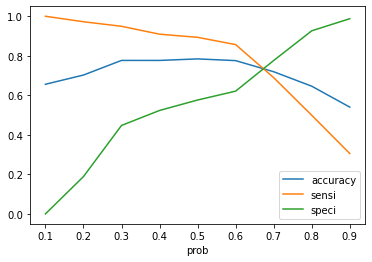

In [164]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**From the curve above, 0.6 is the optimum point to take it as a cutoff probability.**

In [165]:
# Creating a column based on 0.6 cutoff for prediction
y_pred['final_predicted'] = y_pred.default_pred.map( lambda x: 1 if x > 0.6 else 0)

y_pred.head()

,default,default_pred,logreg_pred,y_pred_0.1,y_pred_0.2,y_pred_0.3,y_pred_0.4,y_pred_0.5,y_pred_0.6,y_pred_0.7,y_pred_0.8,y_pred_0.9,final_predicted
0,0,0.174002,0,1,0,0,0,0,0,0,0,0,0
1,0,0.707480,1,1,1,1,1,1,1,1,0,0,1
2,1,0.671867,1,1,1,1,1,1,1,0,0,0,1
3,1,0.673433,1,1,1,1,1,1,1,0,0,0,1
4,0,0.971832,1,1,1,1,1,1,1,1,1,1,1


In [166]:
# Let's check the overall accuracy.
print("accuracy_score - ", accuracy_score(y_pred.default, y_pred.final_predicted))

# Precision Score
print("precision_score - ", precision_score(y_pred.default, y_pred.final_predicted))

# Recall Score
print("recall_score - ", recall_score(y_pred.default, y_pred.final_predicted))

accuracy_score -  0.7754938642277549
precision_score -  0.8115990389749066
recall_score -  0.8565089799272215


**Precision Recall Curve**

In [167]:
p, r, thresholds = precision_recall_curve(y_pred.default, y_pred.default_pred)

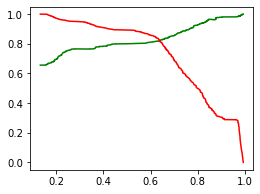

In [168]:
plt.figure(figsize=(4,3))
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

**On Precision & Recall trade off we found optimal cutoff of between "0.6 & 0.7" . Hence keeping the optimal cutoff 0.6.**

**Recall Curve**

In [169]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [170]:
fpr, tpr, thresholds = roc_curve(y_pred.default,y_pred.default_pred,drop_intermediate = False)

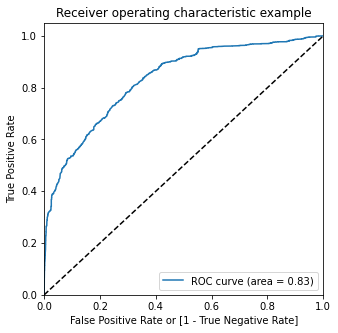

In [171]:
draw_roc(y_pred.default,y_pred.default_pred)

**AUC = 0.83 which shows the model is good.**

## 5. Making Predicitions on Test Data

In [172]:
# Transforming the numerical column of test set
X_test[['USD Amount']]= scaler.transform(X_test[['USD Amount']])
X_test.head()

,USD Amount,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,cluster_id,Invoice_Month
34292,5.562626,0,0,0,0,0,0,1,0,0,0,0,3
41331,0.046221,0,1,0,0,0,0,0,0,0,0,2,12
21678,1.526744,0,0,0,0,0,1,0,0,0,0,0,11
4413,-0.290523,0,0,0,0,0,1,0,0,0,0,0,3
34448,0.940862,0,0,0,0,0,0,0,0,0,1,0,4


In [173]:
# Adding a constant
X_test_sm = sm.add_constant(X_test)

In [174]:
#Making predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

34292    0.547992
41331    0.352623
21678    0.365519
4413     0.241894
34448    0.983751
74144    0.352243
56334    0.877908
65576    0.971833
56735    0.783232
25867    0.623256
dtype: float64

In [175]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [176]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [177]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [178]:
y_test_df.head()

,Default,CustID
34292,0,34292
41331,0,41331
21678,0,21678
4413,0,4413
34448,1,34448


In [179]:
# Removing index for both dataframes to append them side by side
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [180]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [181]:
y_pred_final.head()

,Default,CustID,0
0,0,34292,0.547992
1,0,41331,0.352623
2,0,21678,0.365519
3,0,4413,0.241894
4,1,34448,0.983751


In [182]:
# Renaming the column
y_pred_final= y_pred_final.rename(columns={ 0 : 'Delay_Prob','target':'Delay'})

In [183]:
# Let's see the head of y_pred_final
y_pred_final.head()

,Default,CustID,Delay_Prob
0,0,34292,0.547992
1,0,41331,0.352623
2,0,21678,0.365519
3,0,4413,0.241894
4,1,34448,0.983751


In [184]:
# Creating final prediction on test set based on 0.6 cutoff
y_pred_final['final_predicted'] = y_pred_final.Delay_Prob.map(lambda x: 1 if x >= 0.6 else 0)

In [185]:
y_pred_final.head()

,Default,CustID,Delay_Prob,final_predicted
0,0,34292,0.547992,0
1,0,41331,0.352623,0
2,0,21678,0.365519,0
3,0,4413,0.241894,0
4,1,34448,0.983751,1


In [186]:
# Let's check the overall accuracy.
print("Accuracy is", accuracy_score(y_pred_final.Default, y_pred_final.final_predicted))

#precision score
print("Precision is", precision_score(y_pred_final.Default, y_pred_final.final_predicted))

# Recall Score
print("Recall is", recall_score(y_pred.default, y_pred.final_predicted))

Accuracy is 0.7723369858092329
Precision is 0.8089661576557986
Recall is 0.8565089799272215


**Our train and test accuracy is almost same around 77.2 %**

## 6. Model Building - Random Forest

In [187]:
reg_df.columns

Index(['USD Amount', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'DM', 'INV', 'CM',
       'cluster_id', 'Invoice_Month'],
      dtype='object')

In [188]:
# creating X and y
X= reg_df
y= merged_df['Default']

In [189]:
# Splitting into train and test set
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.3, random_state=42)

In [190]:
# Building a base random forest model to check the accuracy

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [191]:
# predicted values
y_train_pred_rf = rf.predict(X_train_rf)

In [192]:
# Checking accuracy and classification report
accuracy = accuracy_score(y_train_rf, y_train_pred_rf)
print(classification_report(y_train_rf, y_train_pred_rf))
print("Accuracy is : ", accuracy)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     22352
           1       0.95      0.98      0.97     42595

    accuracy                           0.96     64947
   macro avg       0.96      0.95      0.95     64947
weighted avg       0.96      0.96      0.96     64947

Accuracy is :  0.9572882504195729


In [193]:
# Using cross validation to check if our model is overfitting

rf_cv = RandomForestClassifier(random_state=42)

# Compute cross-validation scores on the training data
scores = cross_val_score(rf_cv, X_train_rf, y_train_rf, cv=5, scoring= 'recall')

# Compute the mean and standard deviation of the cross-validation scores
mean_score = scores.mean()
std_score = scores.std()

# Print the mean and standard deviation of the cross-validation scores
print("Mean score:", mean_score)
print("Standard deviation:", std_score)

Mean score: 0.9555112102359432
Standard deviation: 0.002327652458353406


In [194]:
# Creating y_pred for test data
y_test_pred_rf = rf.predict(X_test_rf)

In [195]:
# Checking accuracy and classification report of test data
accuracy = accuracy_score(y_test_rf, y_test_pred_rf)
print(classification_report(y_test_rf, y_test_pred_rf))
print("Accuracy is : ", accuracy)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      9520
           1       0.93      0.96      0.94     18315

    accuracy                           0.92     27835
   macro avg       0.92      0.91      0.92     27835
weighted avg       0.92      0.92      0.92     27835

Accuracy is :  0.9246991198131849


**Hyperparameter Tuning**

In [196]:
#Using Grid search for hyper-parameter tuning
param_grid = {
    'n_estimators': [50, 150],
    'max_depth': [10, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs= -1)

grid_search.fit(X_train_rf, y_train_rf)

# Best Hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best f1 score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_cv_rf = best_rf.predict(X_train_rf)

print(classification_report(y_train_rf, y_pred_cv_rf))

Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best f1 score: 0.939266673797986
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     22352
           1       0.95      0.98      0.97     42595

    accuracy                           0.96     64947
   macro avg       0.96      0.94      0.95     64947
weighted avg       0.96      0.96      0.96     64947



In [197]:
# Test set (testing)
y_pred_test_cv = best_rf.predict(X_test_rf)
print(classification_report(y_test_rf,y_pred_test_cv))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      9520
           1       0.93      0.96      0.94     18315

    accuracy                           0.92     27835
   macro avg       0.92      0.91      0.91     27835
weighted avg       0.92      0.92      0.92     27835



From the above classification report, it can be seen that the f1-score for train and test set is 0.97 and 0.96, which implies that this is a good model. Hence moving forward with this as final model for prediction.

In [198]:
importance = best_rf.feature_importances_
sorted_idx = importance.argsort()[::-1]

# Print the feature ranking
print("Feature ranking:")
for i, idx in enumerate(sorted_idx):
    print(f"{i+1}. {X.columns[idx]} ({importance[idx]:.3f})")

Feature ranking:
1. USD Amount (0.464)
2. Invoice_Month (0.129)
3. 60 Days from EOM (0.115)
4. 30 Days from EOM (0.107)
5. cluster_id (0.055)
6. Immediate Payment (0.041)
7. 15 Days from EOM (0.027)
8. 30 Days from Inv Date (0.013)
9. 60 Days from Inv Date (0.013)
10. 90 Days from Inv Date (0.008)
11. INV (0.007)
12. 90 Days from EOM (0.007)
13. 45 Days from EOM (0.005)
14. 45 Days from Inv Date (0.004)
15. CM (0.004)
16. DM (0.001)


## 7. Preparing Open Invoice dataset for prediction 

The open invoice data includes a column 'AGE,' calculated as the difference between the Transaction Date and AS_OF_DATE. A positive value in the 'AGE' column indicates that the payment is already overdue, eliminating the need for prediction. However, a negative 'AGE' value signifies that the due date has not yet passed. Therefore, the model should predict whether the payment will be delayed only for customers with a negative 'AGE' value.

In [199]:
# Selecting rows with negative age value for prediction
open_reg_df_age = df_open_data[df_open_data['AGE'] < 0]
open_reg_df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM
2,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0
4,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0
5,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0
6,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0
7,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0


In [200]:
open_reg_df_age = pd.merge(open_reg_df_age, cust_dict, how='left', on='Customer_Name')

In [201]:
open_reg_df_age.shape

(28015, 19)

In [202]:
# Null counts
round(open_reg_df_age.isna().sum()/len(open_reg_df_age.index), 4)

Customer_Name            0.0000
Due Date                 0.0000
AGE                      0.0000
USD Amount               0.0000
INV_CREATION_DATE        0.0000
15 Days from EOM         0.0000
30 Days from EOM         0.0000
30 Days from Inv Date    0.0000
45 Days from EOM         0.0000
45 Days from Inv Date    0.0000
60 Days from EOM         0.0000
60 Days from Inv Date    0.0000
90 Days from EOM         0.0000
90 Days from Inv Date    0.0000
Immediate Payment        0.0000
DM                       0.0000
INV                      0.0000
CM                       0.0000
cluster_id               0.0274
dtype: float64

The 'cluster_id' column has 2.7% null values. To improve model prediction, we are removing these null values, as they pertain to new customers whose data is not present in the 'Received Payment' dataset.

In [203]:
# Dropping the rows containing null values
open_reg_df_age.dropna(axis=0, inplace=True)

In [204]:
open_reg_df_age.shape

(27247, 19)

In [205]:
open_reg_df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id
0,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,2.0
1,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2.0
2,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2.0
3,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2.0
4,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2.0


In [206]:
open_reg_df_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 0 to 28014
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Customer_Name          27247 non-null  object        
 1   Due Date               27247 non-null  datetime64[ns]
 2   AGE                    27247 non-null  int64         
 3   USD Amount             27247 non-null  int32         
 4   INV_CREATION_DATE      27247 non-null  datetime64[ns]
 5   15 Days from EOM       27247 non-null  uint8         
 6   30 Days from EOM       27247 non-null  uint8         
 7   30 Days from Inv Date  27247 non-null  uint8         
 8   45 Days from EOM       27247 non-null  uint8         
 9   45 Days from Inv Date  27247 non-null  uint8         
 10  60 Days from EOM       27247 non-null  uint8         
 11  60 Days from Inv Date  27247 non-null  uint8         
 12  90 Days from EOM       27247 non-null  uint8         
 13  9

In [207]:
# converting the cluster_id column to int
open_reg_df_age['cluster_id'] = open_reg_df_age['cluster_id'].astype('Int64')

In [208]:
# Checking the head after adding 'cluster_id' column
open_reg_df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id
0,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,2
1,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2
2,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2
3,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2
4,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2


In [209]:
# Creating a copy of open_reg_df_age for final prediction
open_reg_df_final = open_reg_df_age.copy()

In [210]:
# Dropping Customer_Name and AGE column
open_reg_df_final.drop(['Customer_Name', 'AGE'], axis=1, inplace=True)

In [211]:
open_reg_df_final['Invoice_Month'] = open_reg_df_final['INV_CREATION_DATE'].dt.month # Extracting Month

In [212]:
# dropping due_date and invoice creation date

open_reg_df_final.drop(['Due Date','INV_CREATION_DATE'], axis= 1, inplace= True)

In [213]:
# Checking the columns in the dataset
open_reg_df_final.columns

Index(['USD Amount', '15 Days from EOM', '30 Days from EOM',
       '30 Days from Inv Date', '45 Days from EOM', '45 Days from Inv Date',
       '60 Days from EOM', '60 Days from Inv Date', '90 Days from EOM',
       '90 Days from Inv Date', 'Immediate Payment', 'DM', 'INV', 'CM',
       'cluster_id', 'Invoice_Month'],
      dtype='object')

# Final Prediction based on Random Forest model

In [214]:
# getting predictions on open invoices
y_open_invoices= best_rf.predict_proba(open_reg_df_final)[:,1]
y_open_invoices

array([0.99776241, 0.904329  , 0.04      , ..., 0.27400153, 0.94186646,
       0.03905647])

In [215]:
# Adding the predicted values to the dataframe
open_reg_df_age['Pred_rf'] = y_open_invoices
open_reg_df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Pred_rf
0,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0.997762
1,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.904329
2,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.040000
3,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.000000
4,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.993333


In [216]:
# Customer-wise model prediction
customer_seg_prob= pd.DataFrame(open_reg_df_age.groupby('Customer_Name')['Pred_rf'].prod().round(4))
customer_seg_prob

,Pred_rf
Customer_Name,
3D D Corp,0.0000
6TH Corp,0.0855
ABDU Corp,0.0000
ABEE Corp,0.0361
ABU Corp,0.0005
...,...
XPRE Corp,0.0000
YOUG Corp,0.6975
YOUS Corp,0.0001


In [217]:
# Taking 0.6 as cut off value
open_reg_df_age['Final_Prediction'] = open_reg_df_age.Pred_rf.map(lambda x: 1 if x>0.6 else 0)

In [218]:
# Let us check our final dataframe with predictions
open_reg_df_age.head()

,Customer_Name,Due Date,AGE,USD Amount,INV_CREATION_DATE,15 Days from EOM,30 Days from EOM,30 Days from Inv Date,45 Days from EOM,45 Days from Inv Date,60 Days from EOM,60 Days from Inv Date,90 Days from EOM,90 Days from Inv Date,Immediate Payment,DM,INV,CM,cluster_id,Pred_rf,Final_Prediction
0,AL J Corp,2022-04-23,-18,2000,2022-03-24 17:46:00,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0.997762,1
1,ALLI Corp,2022-04-30,-25,3800,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.904329,1
2,ALLI Corp,2022-04-30,-25,1264,2022-03-03 22:30:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.040000,0
3,ALLI Corp,2022-04-30,-25,25858,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.000000,0
4,ALLI Corp,2022-04-30,-25,39873,2022-03-15 19:06:00,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0.993333,1


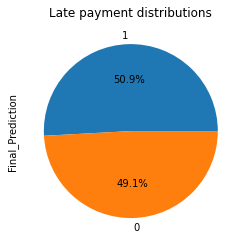

In [219]:
(open_reg_df_age.Final_Prediction.value_counts(normalize = True)*100).plot.pie(autopct='%1.1f%%')
plt.title("Late payment distributions")
plt.show()

**From the above pie chart, we can observe that 50.9% payments in the open invoice data with AGE value negative(indicating due date not crossed)**

# Summary of prediction on Customers_name

In [221]:
# Checking Customers with our target variable_delayed
Delay_payment = open_reg_df_age.groupby(['Customer_Name'])['Final_Prediction'].sum()
Delay_payment = Delay_payment.to_frame()
Delay_payment = Delay_payment.sort_values(by ='Final_Prediction',ascending=False)

In [222]:
# Checking Customers for total invoice counts
Delay_payment_total = open_reg_df_age.groupby(['Customer_Name'])['Final_Prediction'].count() # total payments by each customers
Delay_payment_total = Delay_payment_total.to_frame()
Delay_payment_total = Delay_payment_total.sort_values(by ='Final_Prediction',ascending=False)

In [223]:
# Merging both dataframes based on Customer_name
Merge_df=pd.merge(Delay_payment,Delay_payment_total,how='inner',on='Customer_Name')

In [224]:
# Renaming the columns
Merge_df.columns=["Delayed_Payment","Total_Payments"]

In [225]:
# Creating a column for delay percentage of each customers
Merge_df['Delay%']=np.round(Merge_df['Delayed_Payment']/Merge_df['Total_Payments']*100,2)

In [226]:
# Checking Merge_df
Merge_df.sort_values('Total_Payments',ascending=False)

,Delayed_Payment,Total_Payments,Delay%
Customer_Name,,,
SEPH Corp,4521,8260,54.73
FITR Corp,1483,3454,42.94
PARF Corp,1119,1717,65.17
AREE Corp,712,1117,63.74
ALLI Corp,356,1042,34.17
...,...,...,...
LINT Corp,1,1,100.00
PEAR Corp,1,1,100.00
NOUS Corp,1,1,100.00


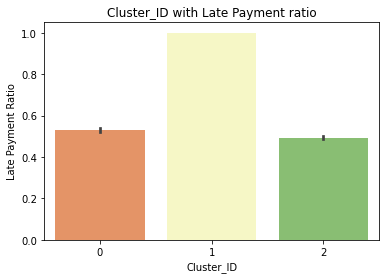

In [227]:
sns.barplot(data=open_reg_df_age, x='cluster_id', y='Final_Prediction', estimator=np.mean, palette='RdYlGn')
plt.title("Cluster_ID with Late Payment ratio")
plt.xlabel("Cluster_ID")
plt.ylabel("Late Payment Ratio")
plt.show()
#cluster ID 1 has significantly higher ratio of default than clusters 0 and 2

In [228]:
Merge_df.sort_values(['Delay%','Total_Payments','Delayed_Payment'],ascending=[False,False,False]).head(10) # top 10 customers with highest delay rates

,Delayed_Payment,Total_Payments,Delay%
Customer_Name,,,
RNA Corp,9,9,100.0
ALSU Corp,7,7,100.0
FEME Corp,5,5,100.0
LVMH Corp,4,4,100.0
V PE Corp,4,4,100.0
SUND Corp,4,4,100.0
MUOS Corp,3,3,100.0
ALTA Corp,3,3,100.0
TRAF Corp,3,3,100.0


# Recommendations Based on Derived Insights

From our clustering analysis, we can make the following inferences and recommendations:

1. **Credit Note Payments**:
   - Credit Note Payments exhibit the highest delay rate compared to Debit Note or Invoice type classes. Therefore, company policies on payment collection should be made stricter for Credit Note invoices.

2. **Goods Type Invoices**:
   - Goods type invoices have significantly higher payment delay rates than non-goods types. Stricter payment policies should be enforced for goods type invoices.

3. **Lower Value Payments**:
   - Lower value payments constitute the majority of transactions and exhibit higher late payment rates. The company should focus more on these payments. It is recommended to implement a penalty system based on billing amount, where smaller bills incur a higher percentage penalty for late payments. This measure should be used as a last resort.

4. **Customer Segments**:
   - Customers were clustered into three categories: 
     - Cluster 0: Medium payment duration
     - Cluster 1: Prolonged payment duration
     - Cluster 2: Early payment duration
   - Customers in Cluster 1 (prolonged payment duration) have significantly higher delay rates than those in the early and medium payment duration clusters. Therefore, extensive focus should be placed on customers in Cluster 1.

5. **High-Risk Companies**:
   - Companies with the highest probability of delayed payments, as well as high total and delayed payment counts, should be prioritized and monitored closely due to their high probability rates.

By implementing these recommendations, the company can improve its payment collection efficiency and reduce the incidence of late payments.